# Machine Learning's Capacity to Beat the Market -- Notebook
## Authors: Nathan Dejesus, Brandon Barker, Jack Lea, Mike Damiano, Ryan Schreck
---
The following notebook contains implemented machine learning algorithms to predict the open and close targets for the [New York Stock Exchange dataset](https://www.kaggle.com/datasets/dgawlik/nyse/data?select=fundamentals.csv). The makeup consists of **Preprocessing**, **Implementations**, and **Analysis** concerning the data's features. 

In [183]:
######PREPROCESSING######
import pandas as pd

# Load the datasets
fundamentals = pd.read_csv('data/fundamentals.csv')
prices = pd.read_csv('data/prices.csv')
#prices_split_adjusted = pd.read_csv('data/prices-split-adjusted.csv')
#securities = pd.read_csv('data/securities.csv')

# Display a few rows of each dataset to check the data
fundamentals_preview = fundamentals.head()
prices_preview = prices.head()
#prices_split_adjusted_preview = prices_split_adjusted.head()
#securities_preview = securities.head()

#print(fundamentals_preview, prices_preview, prices_split_adjusted_preview, securities_preview)
print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


# Convert date columns to datetime format for easier alignment and filtering
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'], errors='coerce')
prices['date'] = pd.to_datetime(prices['date'], format='ISO8601', errors='raise')

print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


fundamental shape:  (1781, 79)
price shape:  (851264, 7)
fundamental shape:  (1781, 79)
price shape:  (851264, 7)


In [184]:
# Ensure the company symbols match across datasets
common_symbols = set(fundamentals['Ticker Symbol']).intersection(set(prices['symbol']))

# Filter the datasets for common symbols only
fundamentals_filtered = fundamentals[fundamentals['Ticker Symbol'].isin(common_symbols)]
prices_filtered = prices[prices['symbol'].isin(common_symbols)]
#prices_split_adjusted_filtered = prices_split_adjusted[prices_split_adjusted['symbol'].isin(common_symbols)]

# Remove rows with NaT values in the date columns to avoid the 'NaTType' normalization error
fundamentals_filtered = fundamentals_filtered.dropna(subset=['Period Ending'])
prices_filtered = prices_filtered.dropna(subset=['date'])

# Preview the filtered datasets to confirm alignment based on common symbols
fundamentals_filtered_preview = fundamentals_filtered.head()
prices_filtered_preview = prices_filtered.head()
#prices_split_adjusted_filtered_preview = prices_split_adjusted_filtered.head()

#print(fundamentals_filtered_preview, prices_filtered_preview, prices_split_adjusted_filtered_preview)
print('shape: ', fundamentals_filtered.shape)
print('shape: ', prices_filtered.shape)

shape:  (1777, 79)
shape:  (760913, 7)


In [185]:
# Resample the prices data to a quarterly basis
prices_quarterly = prices_filtered.set_index('date').groupby('symbol').resample('QE').agg({
    'open': 'mean',
    'close': 'mean',
    'low': 'mean',
    'high': 'mean',
    'volume': 'sum'
}).reset_index()

# Display the resampled quarterly prices data
#print(prices_quarterly)
print('shape: ', prices_quarterly.shape)
fundamentals_filtered.head()


shape:  (12097, 7)


Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2         -5.311000e+09     1.513500e+10        60.0  ...   
3         -6.151000e+09     1.159100e+10        51.0  ...   
4         -2.711820e+08     5.202150e+08        23.0  ...   

   Total Current Assets  Total Current Liabilities  Total Equity  \
0          7.072000e+09               9.011000e+09 -7.987000e+09   
1          1.432300e+10               1.380600e+10 -2.731000e+09   
2          1.175000e+10               1.340400e+10  2.021000e+09   
3          9.985000e+09               1.360500e+10  5.635000e+09   
4          3.184200e+09               2.559638e+09  1.210694e+09   

   Total Liabilities  Total Liabilities & Equity  Total Revenue  \
0       2.489100e+10                1.690400e+10   2.485500e+10   
1       4.500900e+10                4.227800e+10   2.674300e+10   
2       4.120400e+10                4.322500e+10   4.265000e+10   
3       4.278000e+10                4.841500e+10   4.099000e+10   
4       3.403120e+09                4.613814e+09   6.205003e+09   

   Treasury Stock  For Year  Earnings Per Share  Estimated Shares Outstanding  
0    -367000000.0    2012.0               -5.60                  3.350000e+08  
1             0.0    2013.0              -11.25                  1.630222e+08  
2             0.0    2014.0                4.02                  7.169154e+08  
3             0.0    2015.0               11.39                  6.681299e+08  
4     -27095000.0    2012.0                5.29                  7.328355e+07  

[5 rows x 79 columns]

In [186]:
# Align fundamentals with prices data based on company symbols and nearest corresponding quarters
# Merge fundamentals and quarterly prices data on 'Ticker Symbol' and 'symbol' (company symbols) and the nearest quarter end dates

# Renaming 'Ticker Symbol' in fundamentals to match 'symbol' for merging
fundamentals_filtered = fundamentals_filtered.rename(columns={'Ticker Symbol': 'symbol'})

# Merging with nearest join on date within the same quarter period
aligned_data = pd.merge_asof(prices_quarterly.sort_values('date'), 
                             fundamentals_filtered.sort_values('Period Ending'), 
                             by='symbol', 
                             left_on='date', 
                             right_on='Period Ending', 
                             direction='backward')

# Display a preview of the aligned dataset
#print(aligned_data.head())
print('shape: ', aligned_data.shape)
print(aligned_data)


shape:  (12097, 85)
      symbol       date       open      close        low       high  \
0        AAL 2010-03-31   6.468361   6.494754   6.320820   6.663443   
1        HAR 2010-03-31  41.127705  41.262131  40.575901  41.760164   
2         KR 2010-03-31  21.514098  21.568361  21.355574  21.745738   
3       NTRS 2010-03-31  52.970984  53.009836  52.435737  53.504918   
4       VIAB 2010-03-31  30.260984  30.297869  29.902131  30.610983   
...      ...        ...        ...        ...        ...        ...   
12092    COG 2016-12-31  22.575238  22.487778  22.128571  22.934762   
12093   QCOM 2016-12-31  67.303333  67.181586  66.515079  67.940952   
12094    COL 2016-12-31  88.023492  88.146191  87.388413  88.725238   
12095    GIS 2016-12-31  61.947302  61.948095  61.512857  62.345555   
12096    ZTS 2016-12-31  50.953651  50.840317  50.394921  51.290159   

             volume  Unnamed: 0 Period Ending  Accounts Payable  ...  \
0      6.670161e+08         NaN           NaT          

In [187]:
aligned_data_cleaned = aligned_data.dropna()
aligned_data_cleaned = aligned_data_cleaned.drop(columns=['Unnamed: 0']) # drop the unnamed column
print('shape: ', aligned_data_cleaned.shape)
aligned_data_cleaned.head()

shape:  (5243, 84)


symbol       date       open      close        low       high  \
3769    BBY 2012-03-31  25.046290  25.079355  24.710968  25.405806   
3993    BBY 2012-06-30  20.450794  20.450476  20.103492  20.842857   
4473    BBY 2012-09-30  18.744921  18.659206  18.329206  19.058254   
4624    CXO 2012-12-31  85.449033  85.178387  84.151451  86.481613   
4628    GPC 2012-12-31  62.536774  62.532419  62.011129  63.064678   

           volume Period Ending  Accounts Payable  Accounts Receivable  ...  \
3769  384639000.0    2012-03-03      7.876000e+09           41000000.0  ...   
3993  568475600.0    2012-03-03      7.876000e+09           41000000.0  ...   
4473  602073500.0    2012-03-03      7.876000e+09           41000000.0  ...   
4624   61617200.0    2012-12-31      3.918140e+08          -23091000.0  ...   
4628   47447900.0    2012-12-31      2.237638e+09           13366000.0  ...   

      Total Current Assets  Total Current Liabilities  Total Equity  \
3769          1.029700e+10               8.855000e+09  3.745000e+09   
3993          1.029700e+10               8.855000e+09  3.745000e+09   
4473          1.029700e+10               8.855000e+09  3.745000e+09   
4624          4.588820e+08               7.400860e+08  3.466196e+09   
4628          4.820131e+09               2.487638e+09  2.997887e+09   

      Total Liabilities  Total Liabilities & Equity  Total Revenue  \
3769       1.226000e+10                1.600500e+10   4.545700e+10   
3993       1.226000e+10                1.600500e+10   4.545700e+10   
4473       1.226000e+10                1.600500e+10   4.545700e+10   
4624       5.123241e+09                8.589437e+09   1.819814e+09   
4628       3.809174e+09                6.807061e+09   1.301387e+10   

      Treasury Stock  For Year  Earnings Per Share  \
3769             0.0    2012.0               -3.36   
3993             0.0    2012.0               -3.36   
4473             0.0    2012.0               -3.36   
4624      -7186000.0    2012.0                4.18   
4628             0.0    2012.0                4.17   

      Estimated Shares Outstanding  
3769                  3.663690e+08  
3993                  3.663690e+08  
4473                  3.663690e+08  
4624                  1.032749e+08  
4628                  1.554055e+08  

[5 rows x 84 columns]

## Feature Selection
---
The following code implements feature selection techniques to identify the most relevant features for predicting stock prices. The techniques used include Recursive Feature Elimination (RFE) and Sequential Feature Selection (Forward Selection). The top 50 features are selected for each technique and the common features are identified. All correlated features are removed to avoid multicollinearity and the remaining features are used for model building.

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Display descriptive statistics for the cleaned dataset
# desc_stats = aligned_data_cleaned.describe()
# print(desc_stats)

# Calculate correlations for key financial metrics and stock prices
print_corr = aligned_data_cleaned.drop(columns=['symbol']).corr().unstack().sort_values(ascending=False)
# print(print_corr['open'])

# List number of features & features
print('Number of features: ', len(aligned_data_cleaned.columns))

# Select features and target variables: open and close prices
features = aligned_data_cleaned.drop(columns=['symbol', 'date', 'Period Ending', 'open', 'close'])
target_open = aligned_data_cleaned['open']
target_close = aligned_data_cleaned['close']

# Perform feature selection using Recursive Feature Elimination (RFE) with a linear regression estimator
RFE_selector_open = RFE(LinearRegression(), n_features_to_select=50)  # Select top 50 features
RFE_selector_open = RFE_selector_open.fit(features, target_open)
RFE_selector_close = RFE(LinearRegression(), n_features_to_select=50)  # Select top 50 features
RFE_selector_close = RFE_selector_close.fit(features, target_close)

# Perform feature selection using Sequential Feature Selector (SFS) with a linear regression estimator
SFS_selector_open = SequentialFeatureSelector(LinearRegression(), n_features_to_select=50, direction='forward')
SFS_selector_open = SFS_selector_open.fit(features, target_open)
SFS_selector_close = SequentialFeatureSelector(LinearRegression(), n_features_to_select=50, direction='forward')
SFS_selector_close = SFS_selector_close.fit(features, target_close)



# Get selected features and their importance - RFE
selected_features_open = features.columns[RFE_selector_open.support_]
feature_importance_open = pd.Series(RFE_selector_open.ranking_, index=features.columns)
selected_features_close = features.columns[RFE_selector_close.support_]
feature_importance_close = pd.Series(RFE_selector_close.ranking_, index=features.columns)

# Get selected features - SFS
selected_features_open_sfs = features.columns[SFS_selector_open.support_]
selected_features_close_sfs = features.columns[SFS_selector_close.support_]


# Print number of selected features and their importance
# print('Number of selected features (open): ', len(selected_features_open))
# print('Selected features (open): ', selected_features_open)
# print('Feature importance (open): ', feature_importance_open.sort_values(ascending=True))
# print('Number of selected features (close): ', len(selected_features_close))
# print('Selected features (close): ', selected_features_close)
# print('Feature importance (close): ', feature_importance_close.sort_values(ascending=True))

# Compare selected features from RFE and SFS and select common features
common_features_open = set(selected_features_open).intersection(set(selected_features_open_sfs))
common_features_close = set(selected_features_close).intersection(set(selected_features_close_sfs))
print('Number of common features (open): ', len(common_features_open))
print('Common features (open): ', common_features_open)
print('Number of common features (close): ', len(common_features_close))
print('Common features (close): ', common_features_close)


Number of features:  84
Number of common features (open):  33
Common features (open):  {'low', 'Cash and Cash Equivalents', 'For Year', 'Other Current Liabilities', 'Total Revenue', 'Profit Margin', 'Cost of Revenue', 'Total Equity', 'Short-Term Debt / Current Portion of Long-Term Debt', 'Short-Term Investments', 'Investments', 'Total Current Assets', 'Gross Margin', 'Net Receivables', 'volume', 'Net Cash Flow', 'Other Investing Activities', 'Pre-Tax Margin', 'Pre-Tax ROE', 'Changes in Inventories', 'Net Cash Flows-Investing', 'Capital Expenditures', 'high', 'Misc. Stocks', 'Other Assets', 'Other Current Assets', 'Deferred Liability Charges', 'Interest Expense', 'Other Liabilities', 'Estimated Shares Outstanding', 'Gross Profit', 'Liabilities', 'Current Ratio'}
Number of common features (close):  30
Common features (close):  {'low', 'Earnings Before Interest and Tax', 'For Year', 'Other Current Liabilities', 'Accounts Payable', 'Total Equity', 'Short-Term Debt / Current Portion of Long

Remaining features (open):  30
Remaining features (close):  26


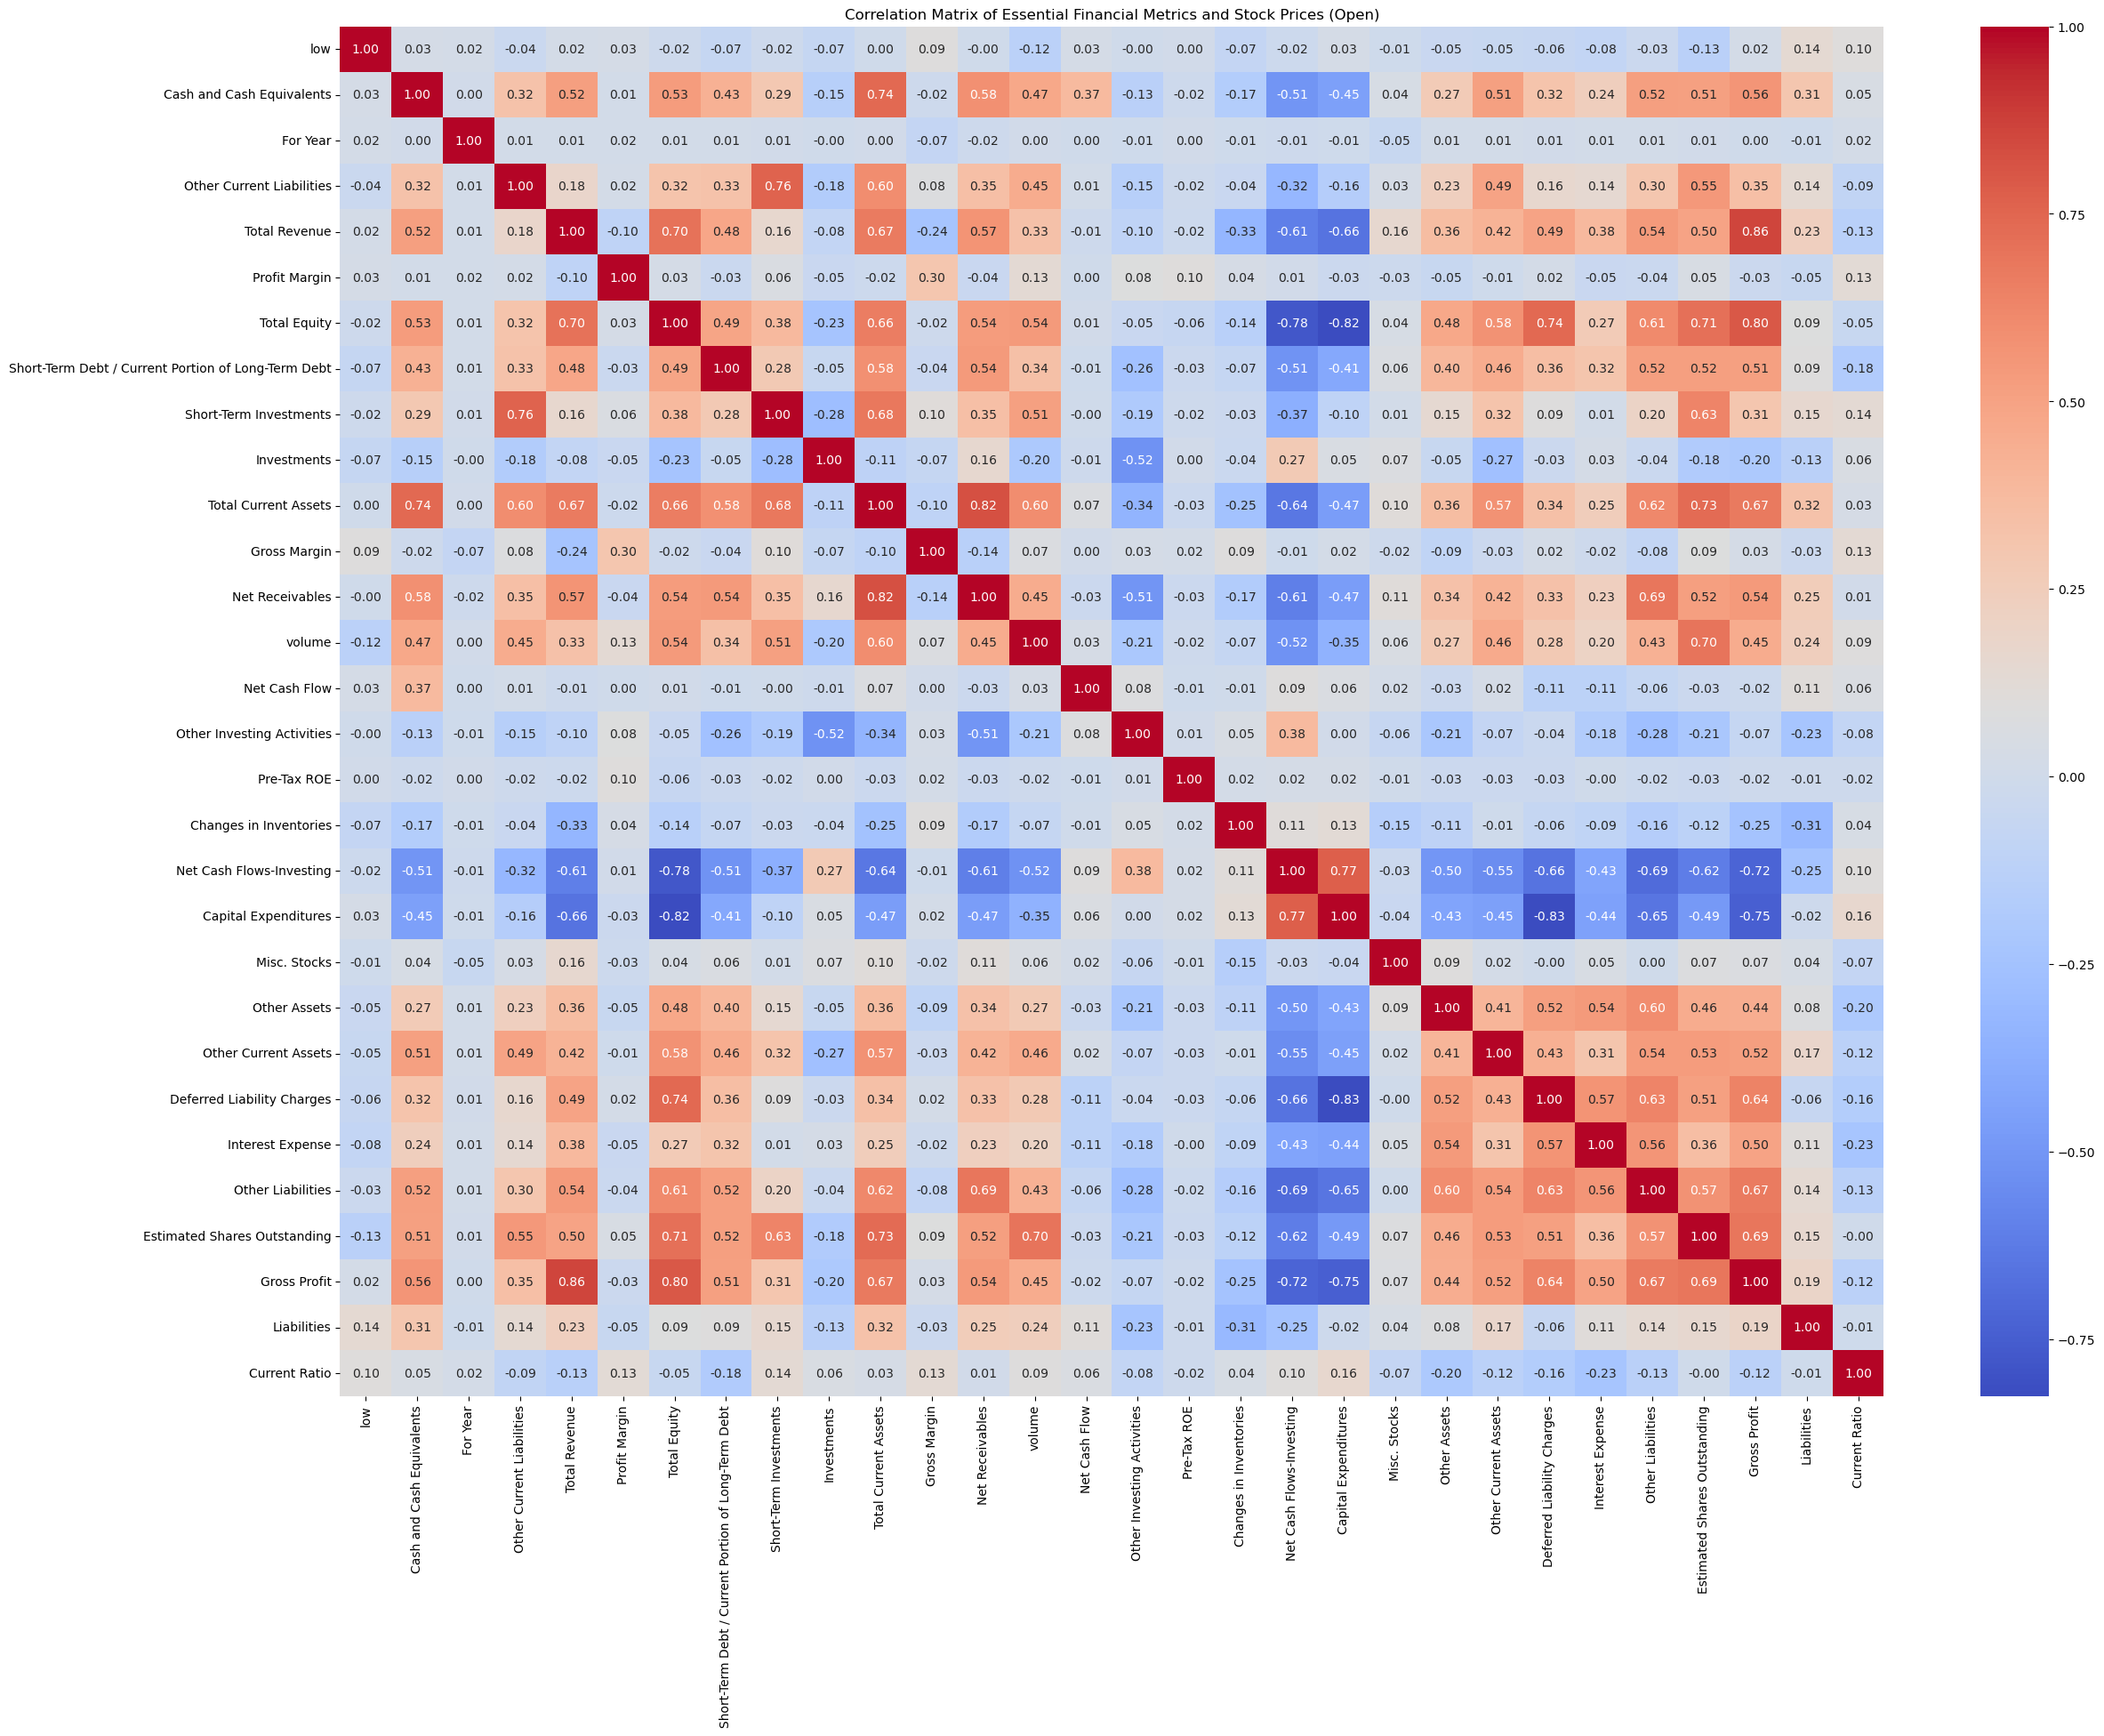

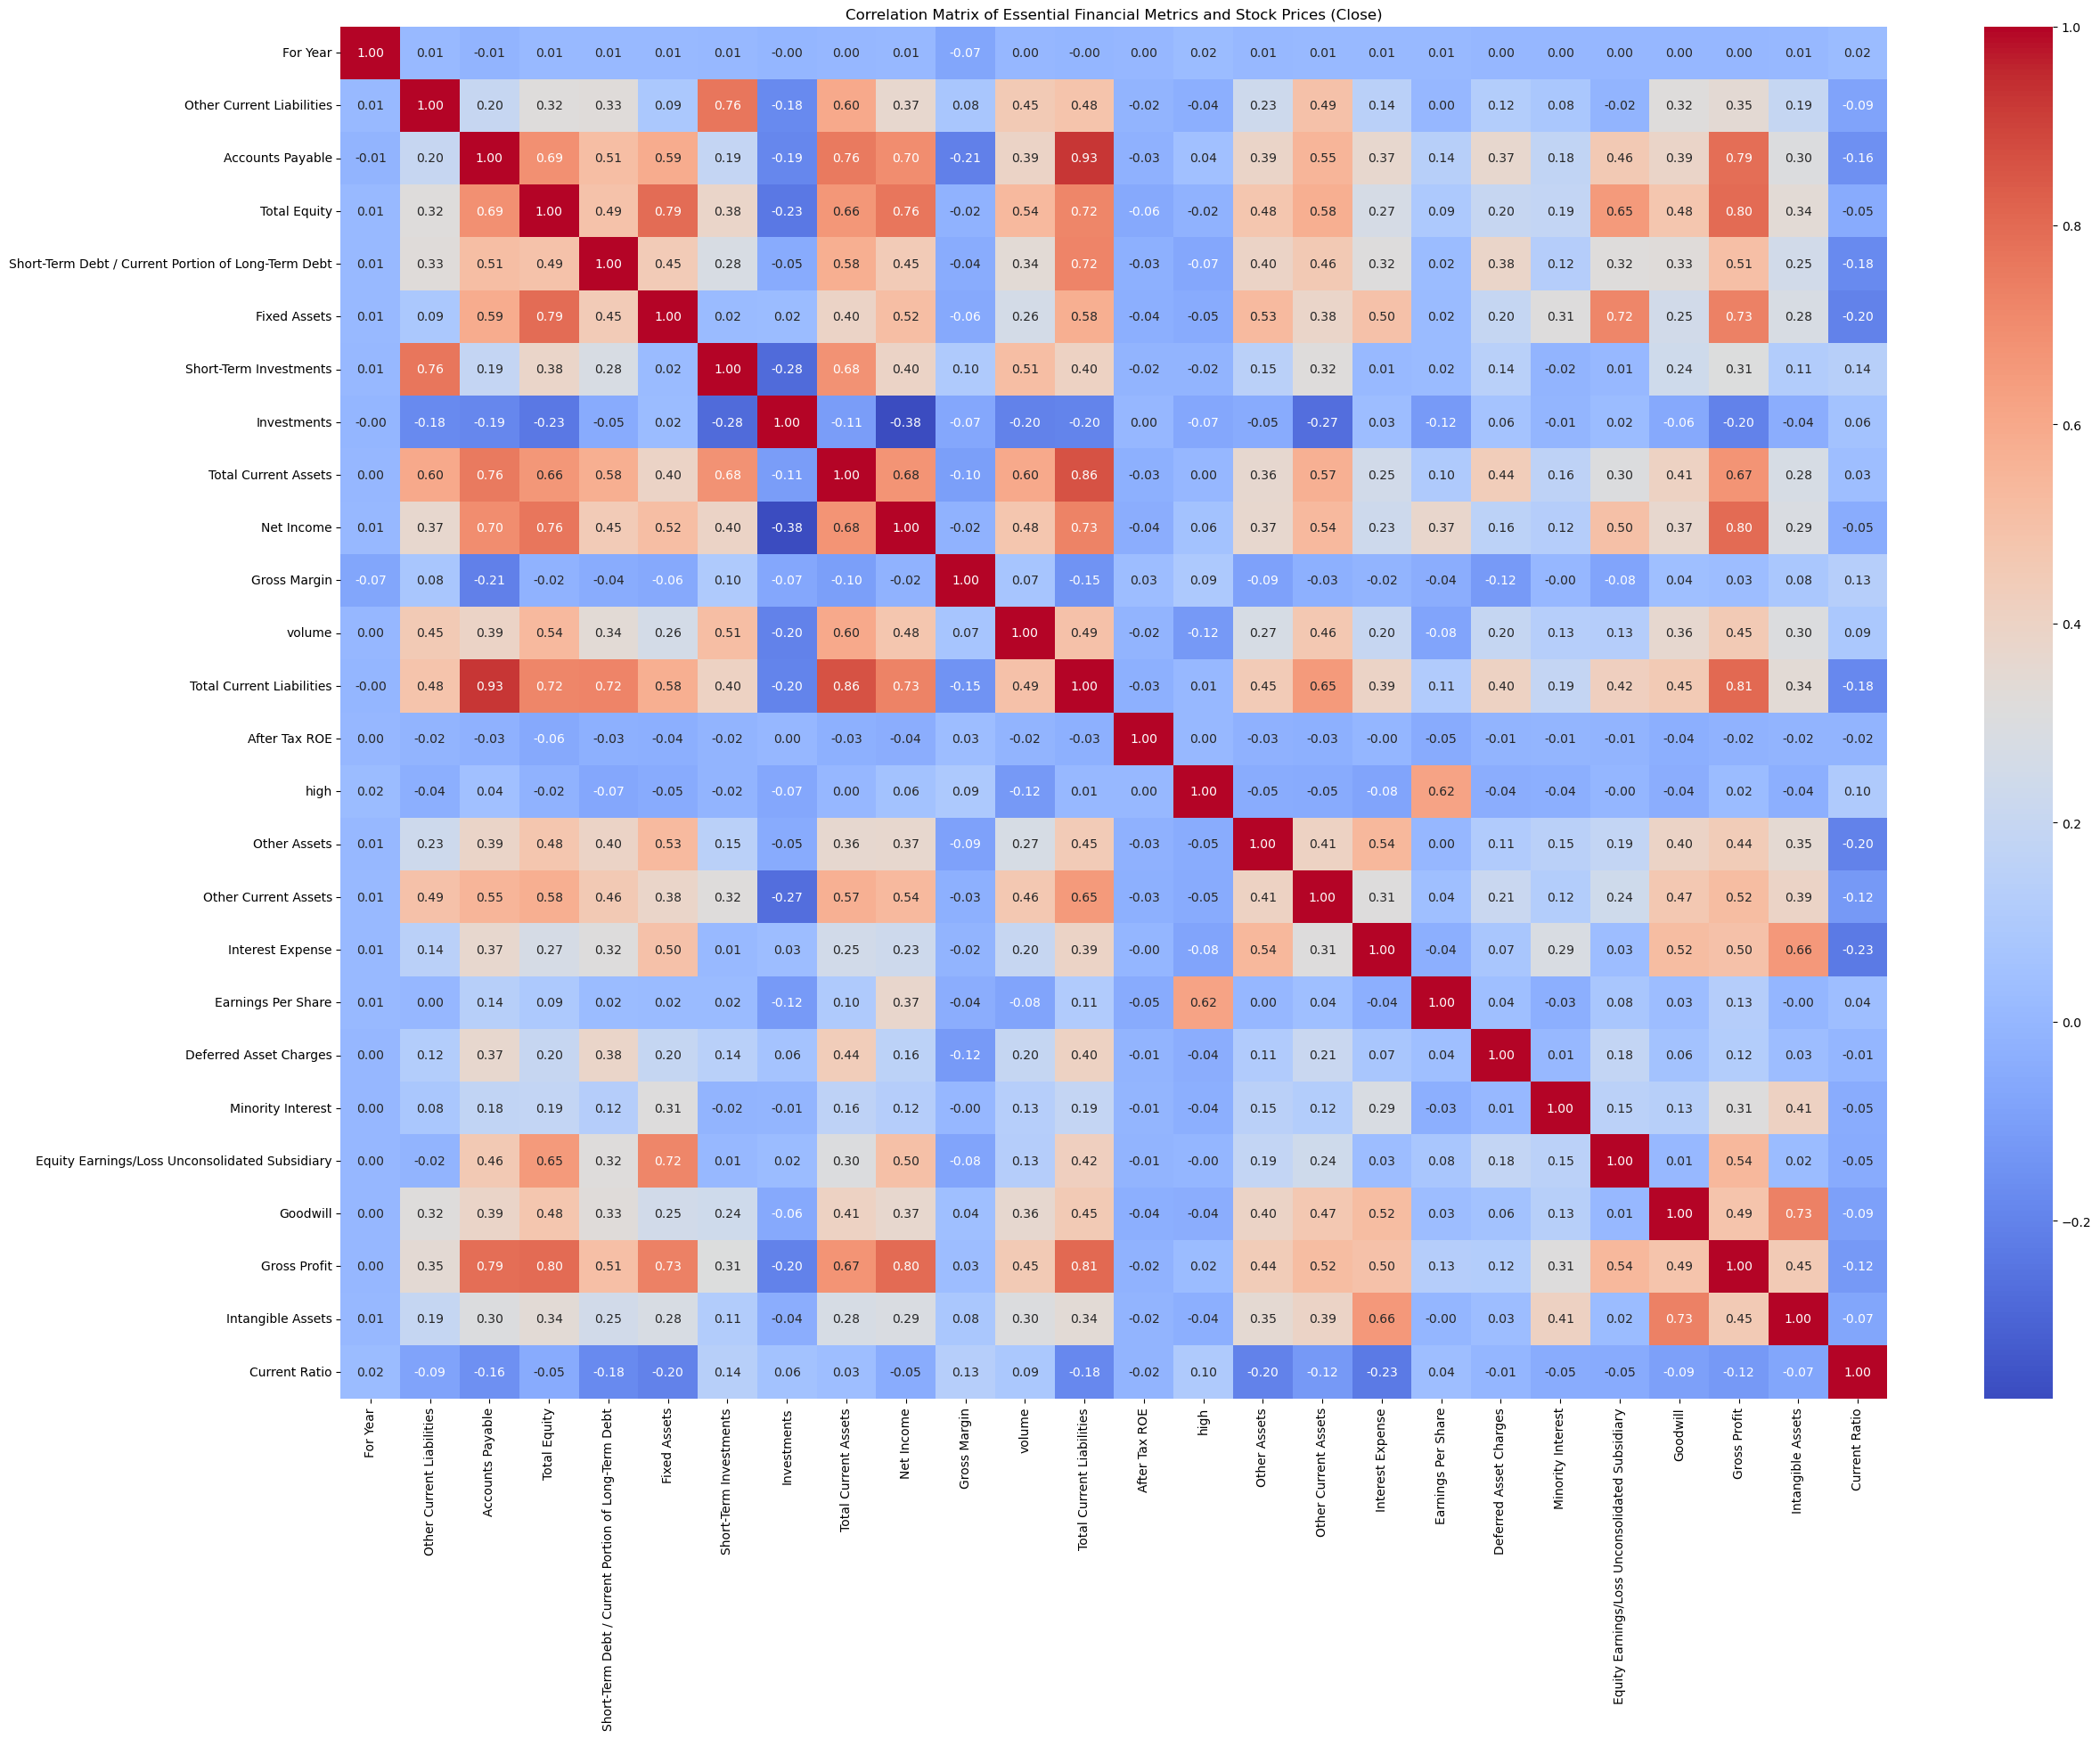

In [190]:
# Filter the aligned data for essential columns only for both open and close prices
selected_data_open = aligned_data_cleaned[list(common_features_open)]
selected_data_close = aligned_data_cleaned[list(common_features_close)]

# Remove Correlated Features For Open - Pre-tax Margin and Cost of Revenue, High
selected_data_open = selected_data_open.drop(columns=['Pre-Tax Margin', 'Cost of Revenue', 'high'])
# Remove Correlated Features For Close - Earnings Before Tax, Earnings Before Interest and Tax, Net Income Applicable to Common Shareholders, Low
selected_data_close = selected_data_close.drop(columns=['Earnings Before Interest and Tax', 'Net Income Applicable to Common Shareholders', 'low', 'Earnings Before Tax'])

# Remaining Features
print('Remaining features (open): ', len(selected_data_open.columns))
print('Remaining features (close): ', len(selected_data_close.columns))


# Calculate the correlation matrix for the selected data
correlation_matrix_open = selected_data_open.corr()
correlation_matrix_close = selected_data_close.corr()


# Visualize the correlation matrices using a heatmap
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_open, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Open)")
plt.show()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_close, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Close)")
plt.show()



## Data Visuaualization
---
The following code visualizes the selected features and their relationships with the target variables (open and close prices). The visualizations include scatter plots, correlation heatmaps, and pair plots. The visualizations help to understand the relationships between the features and the target variables, and to identify any patterns or trends that may be useful for predicting stock prices.





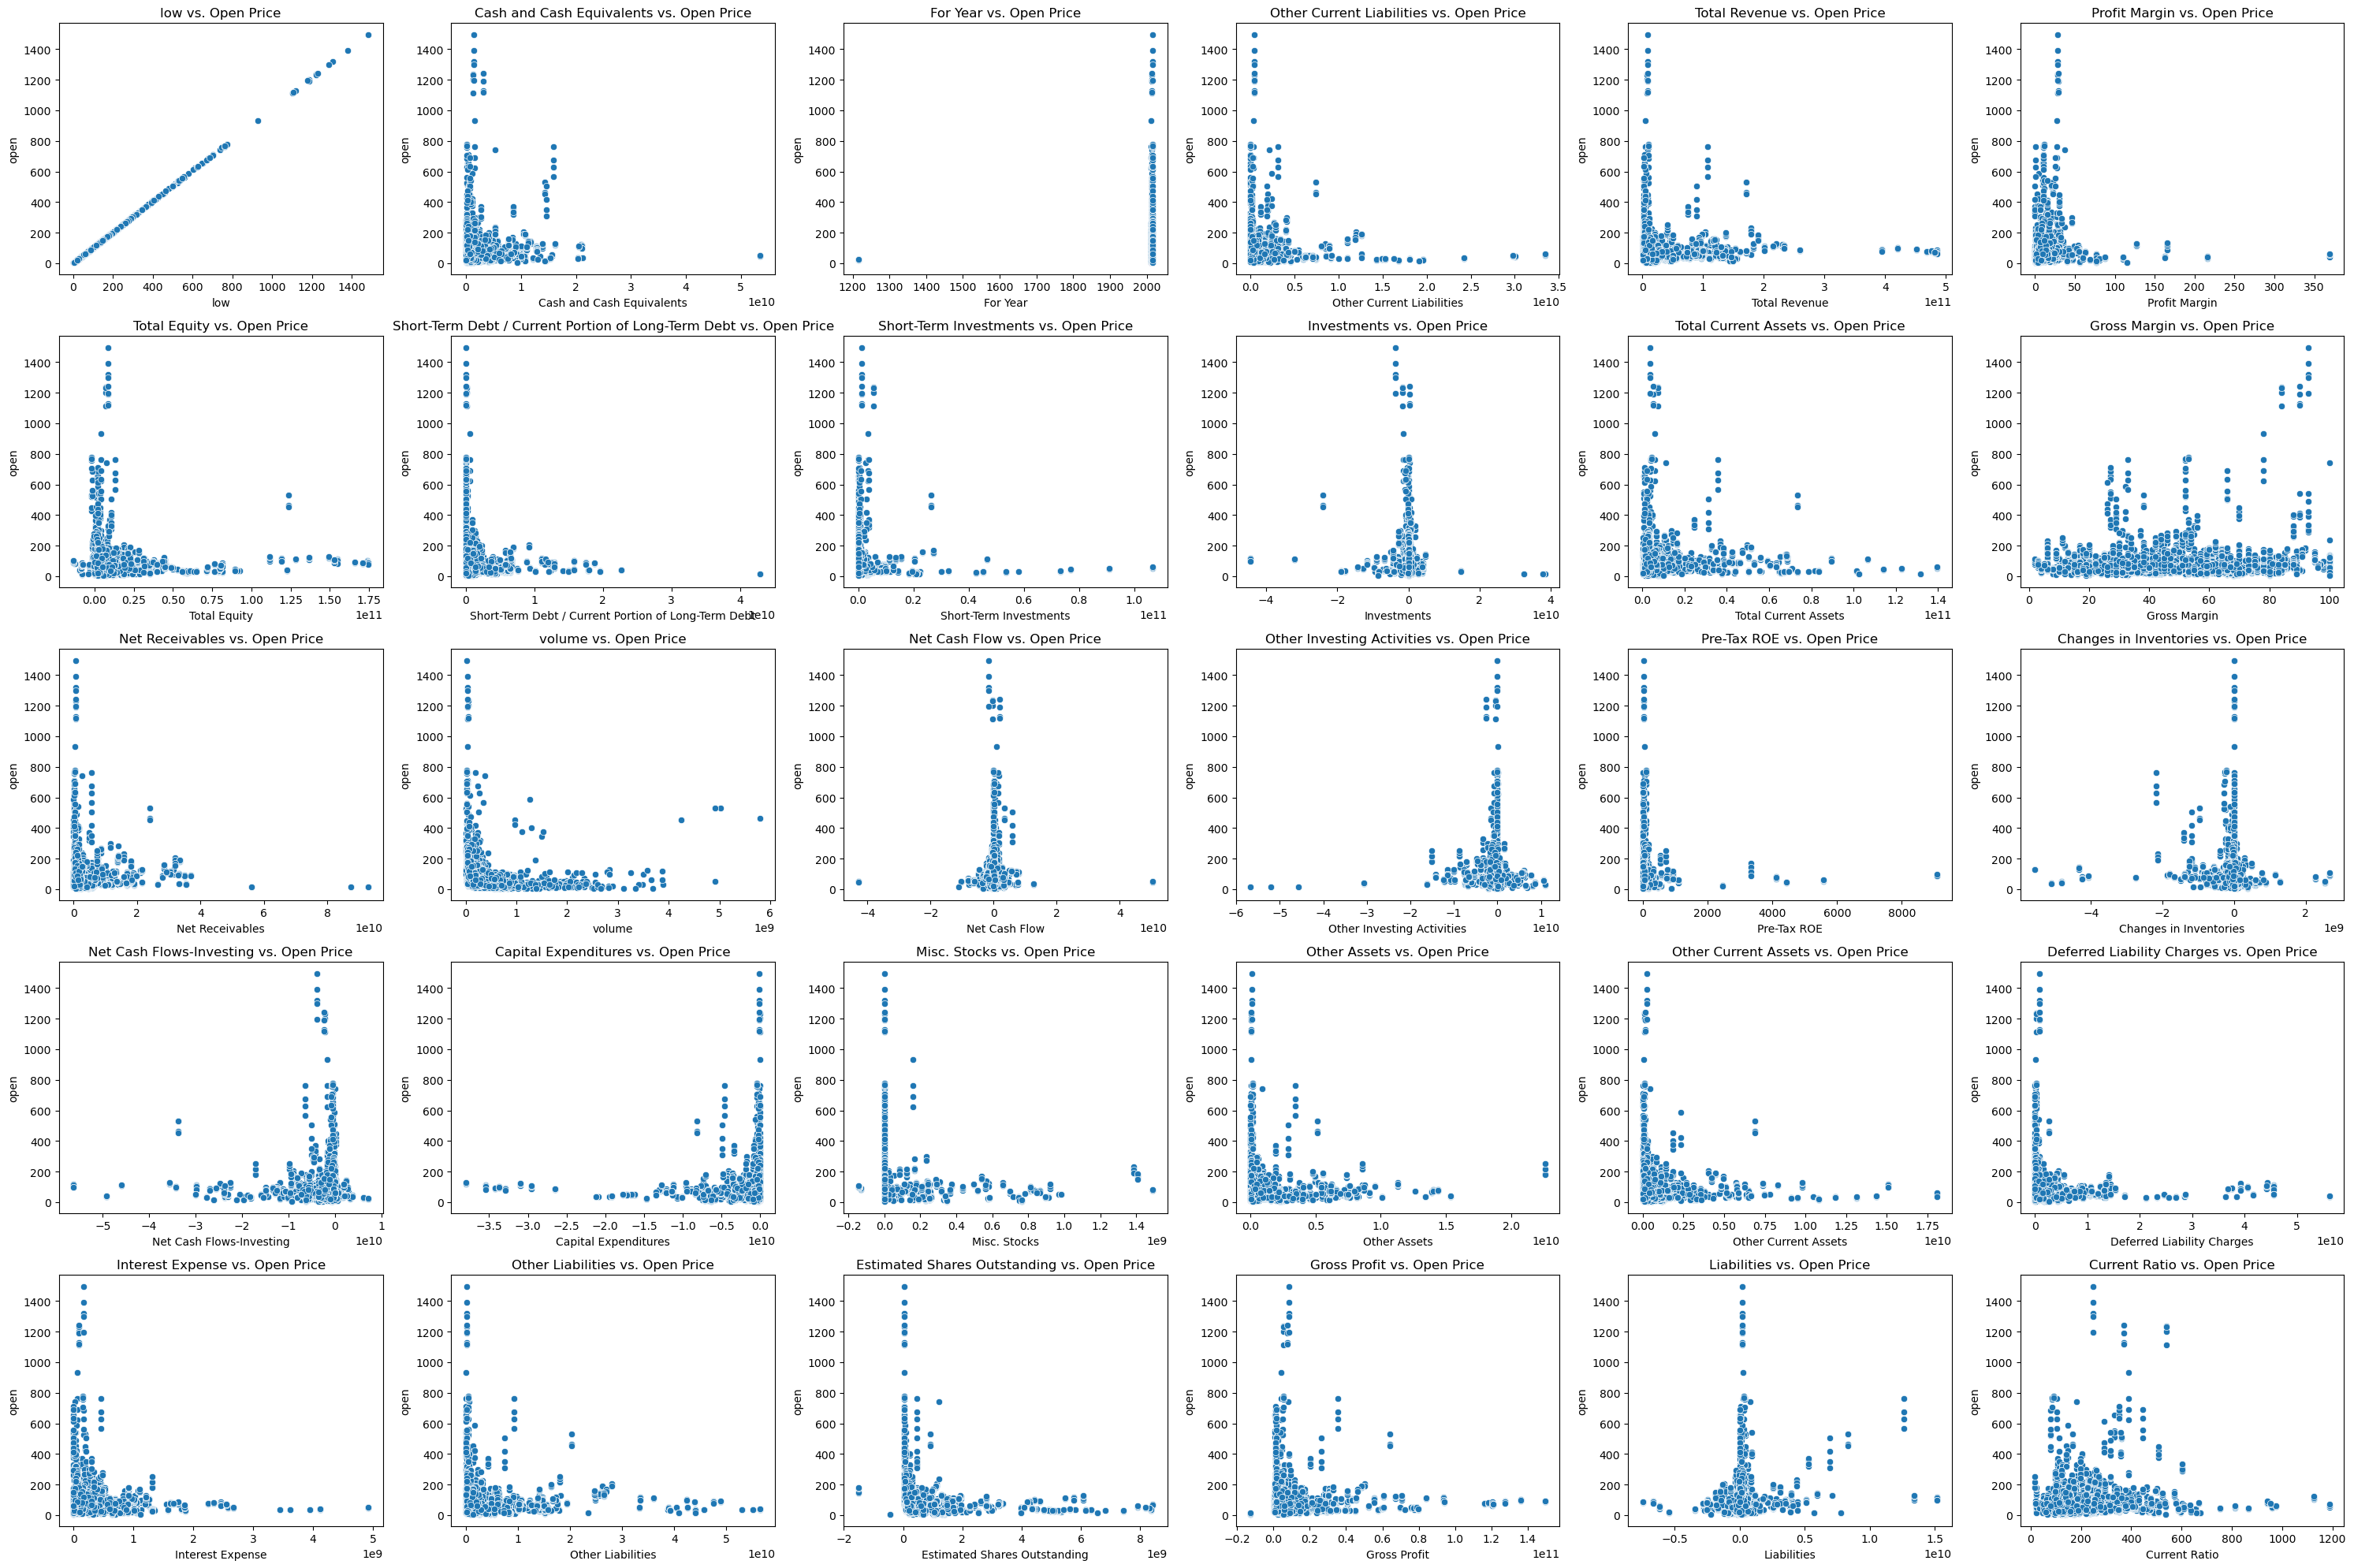

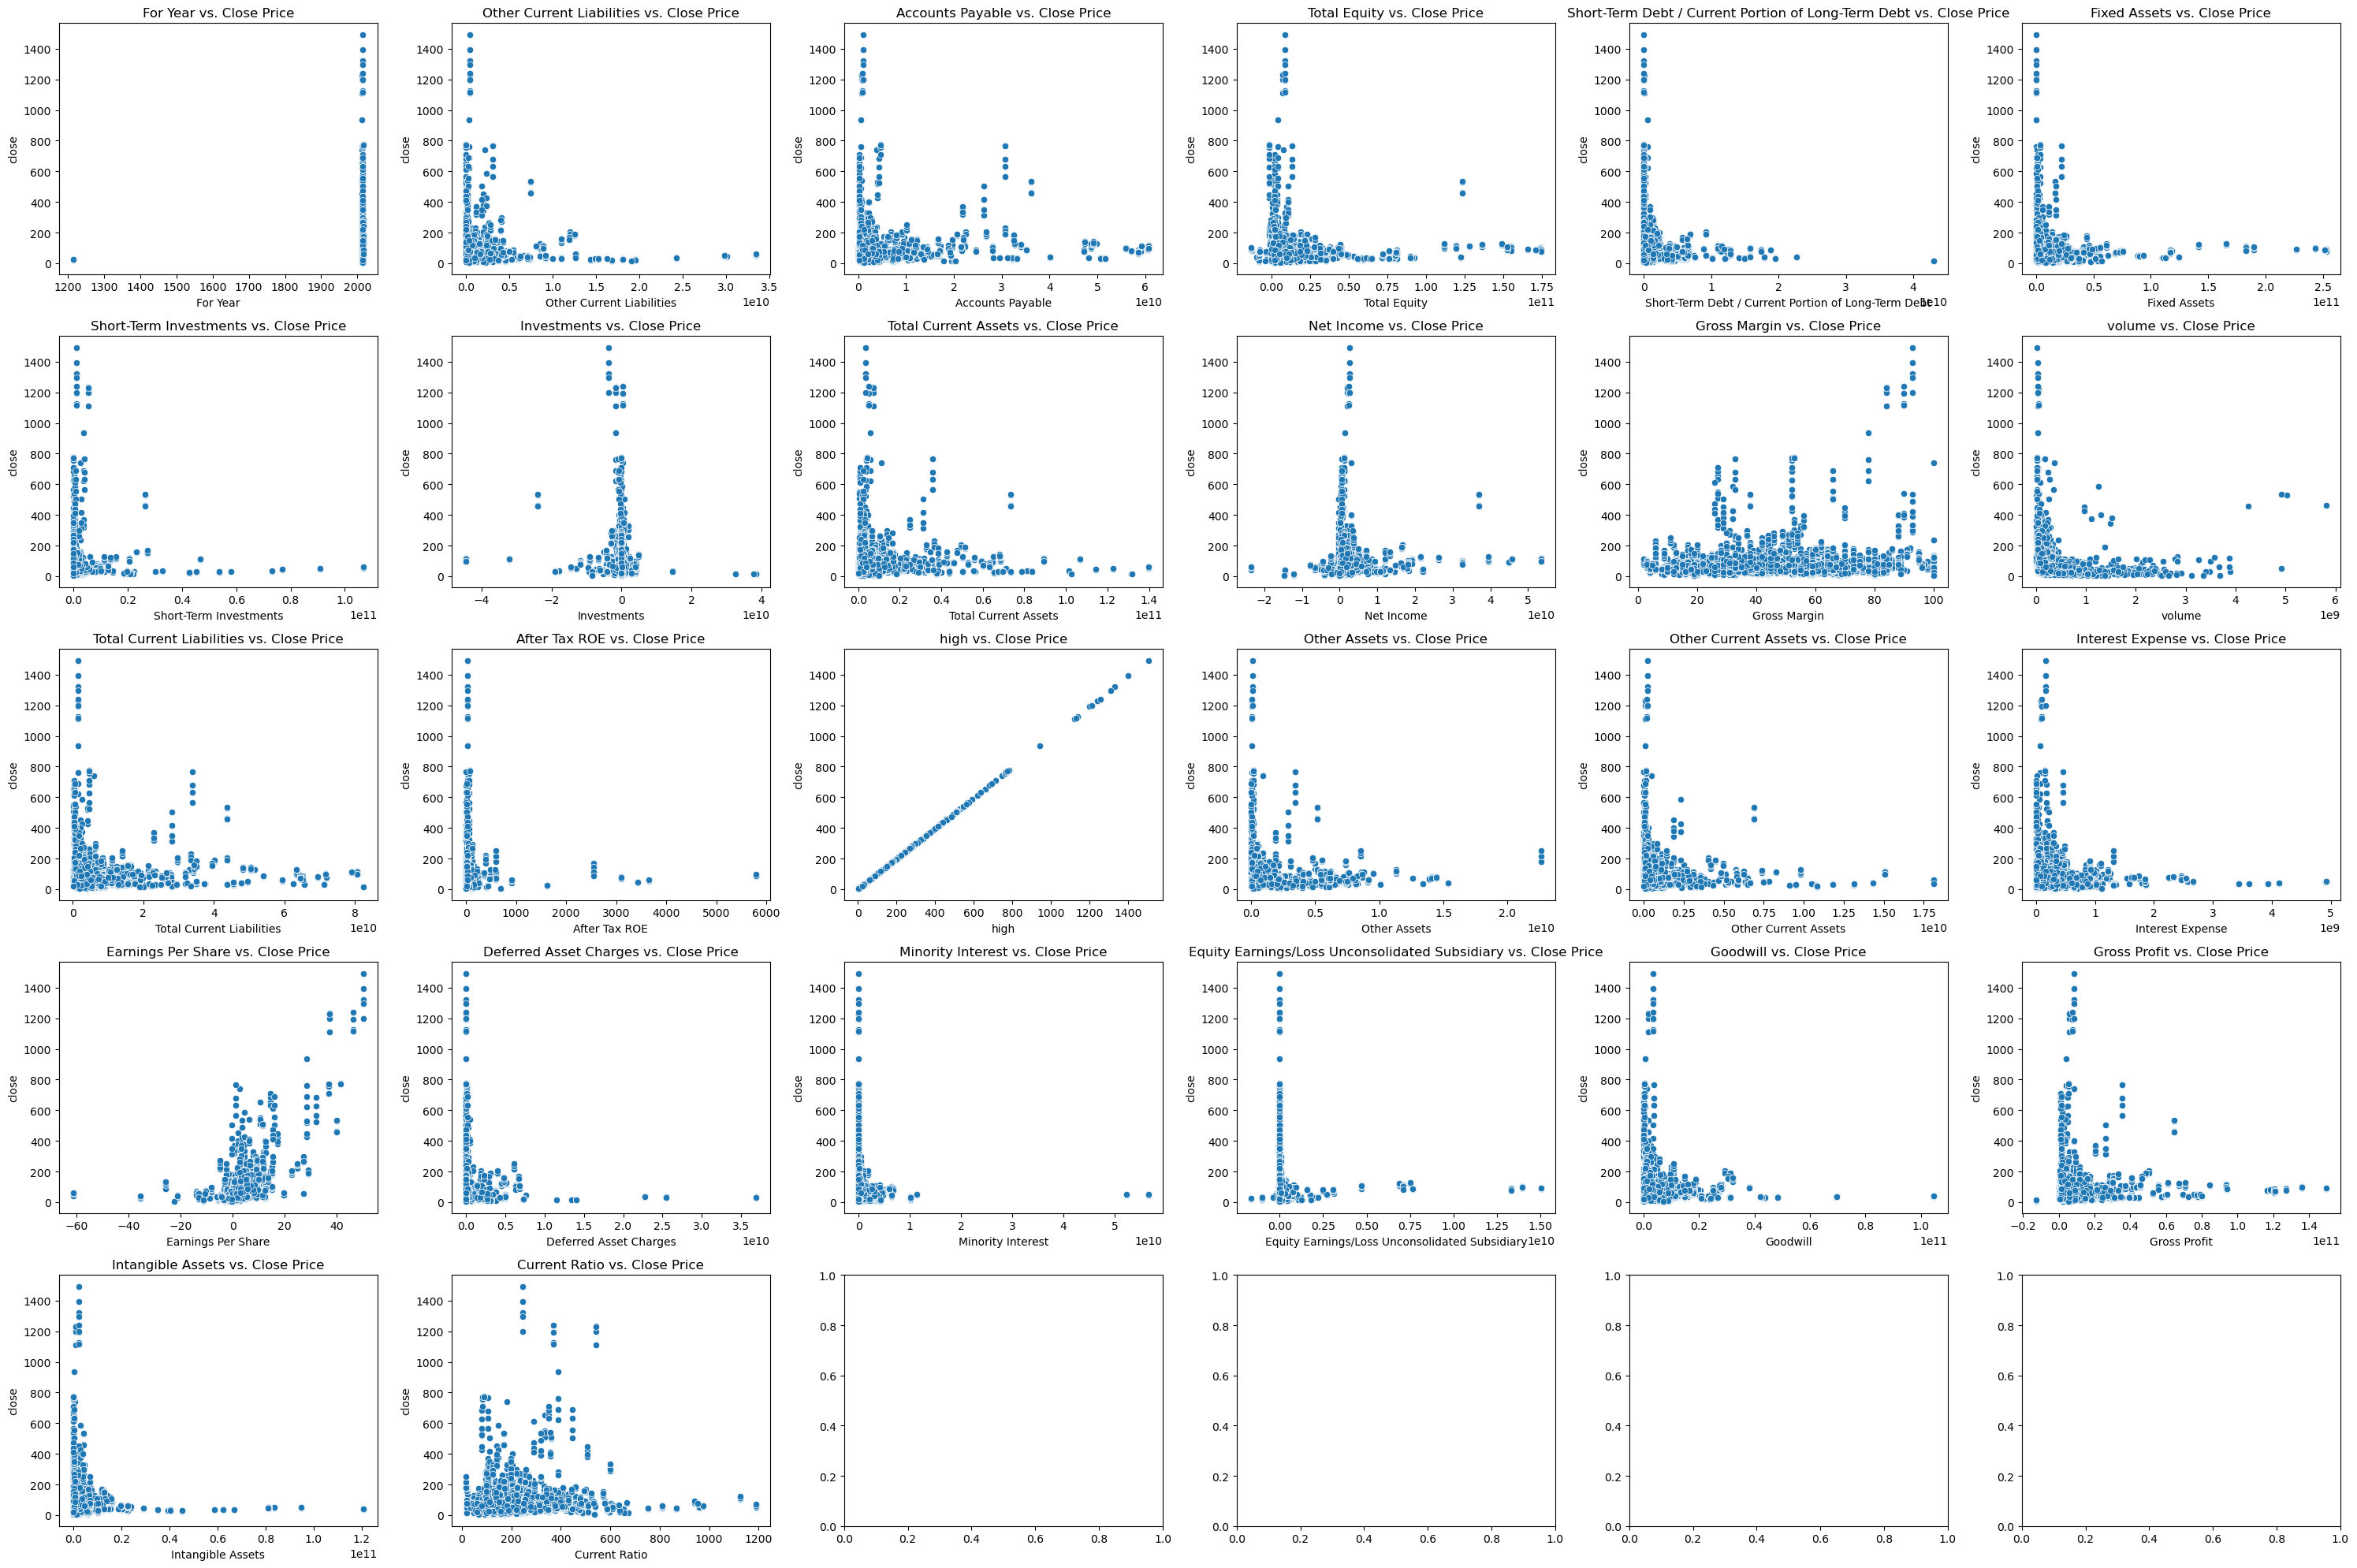

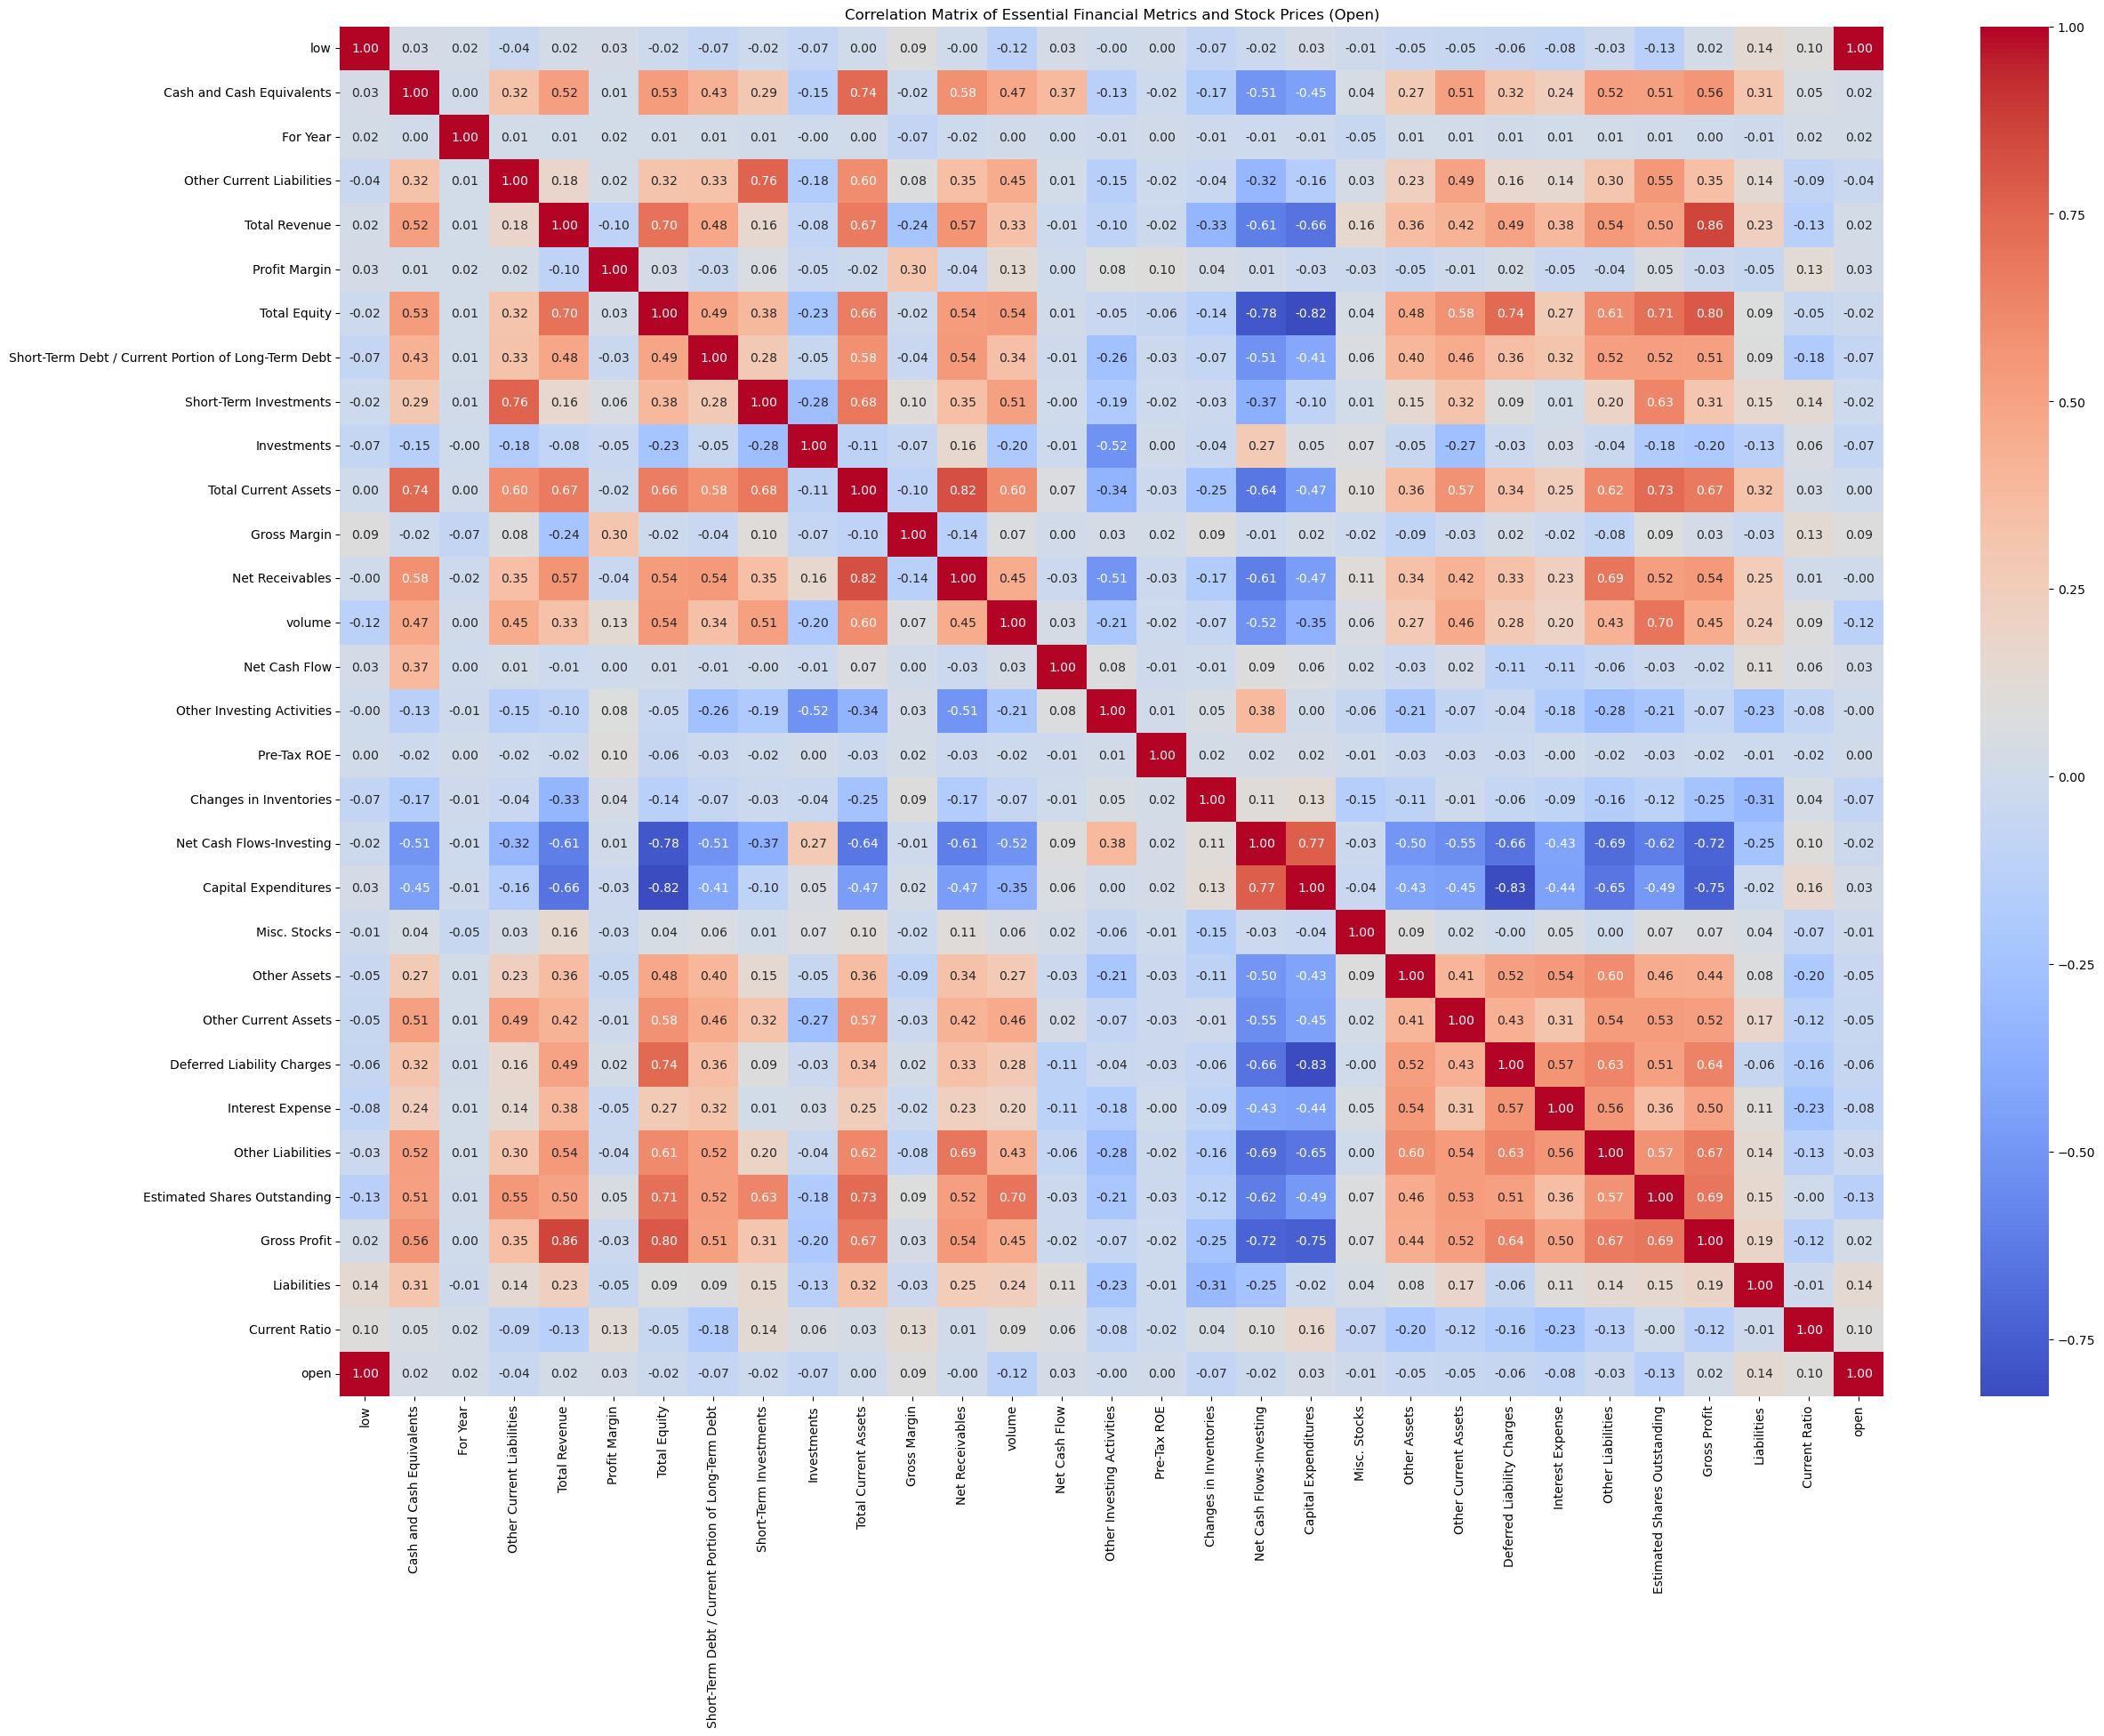

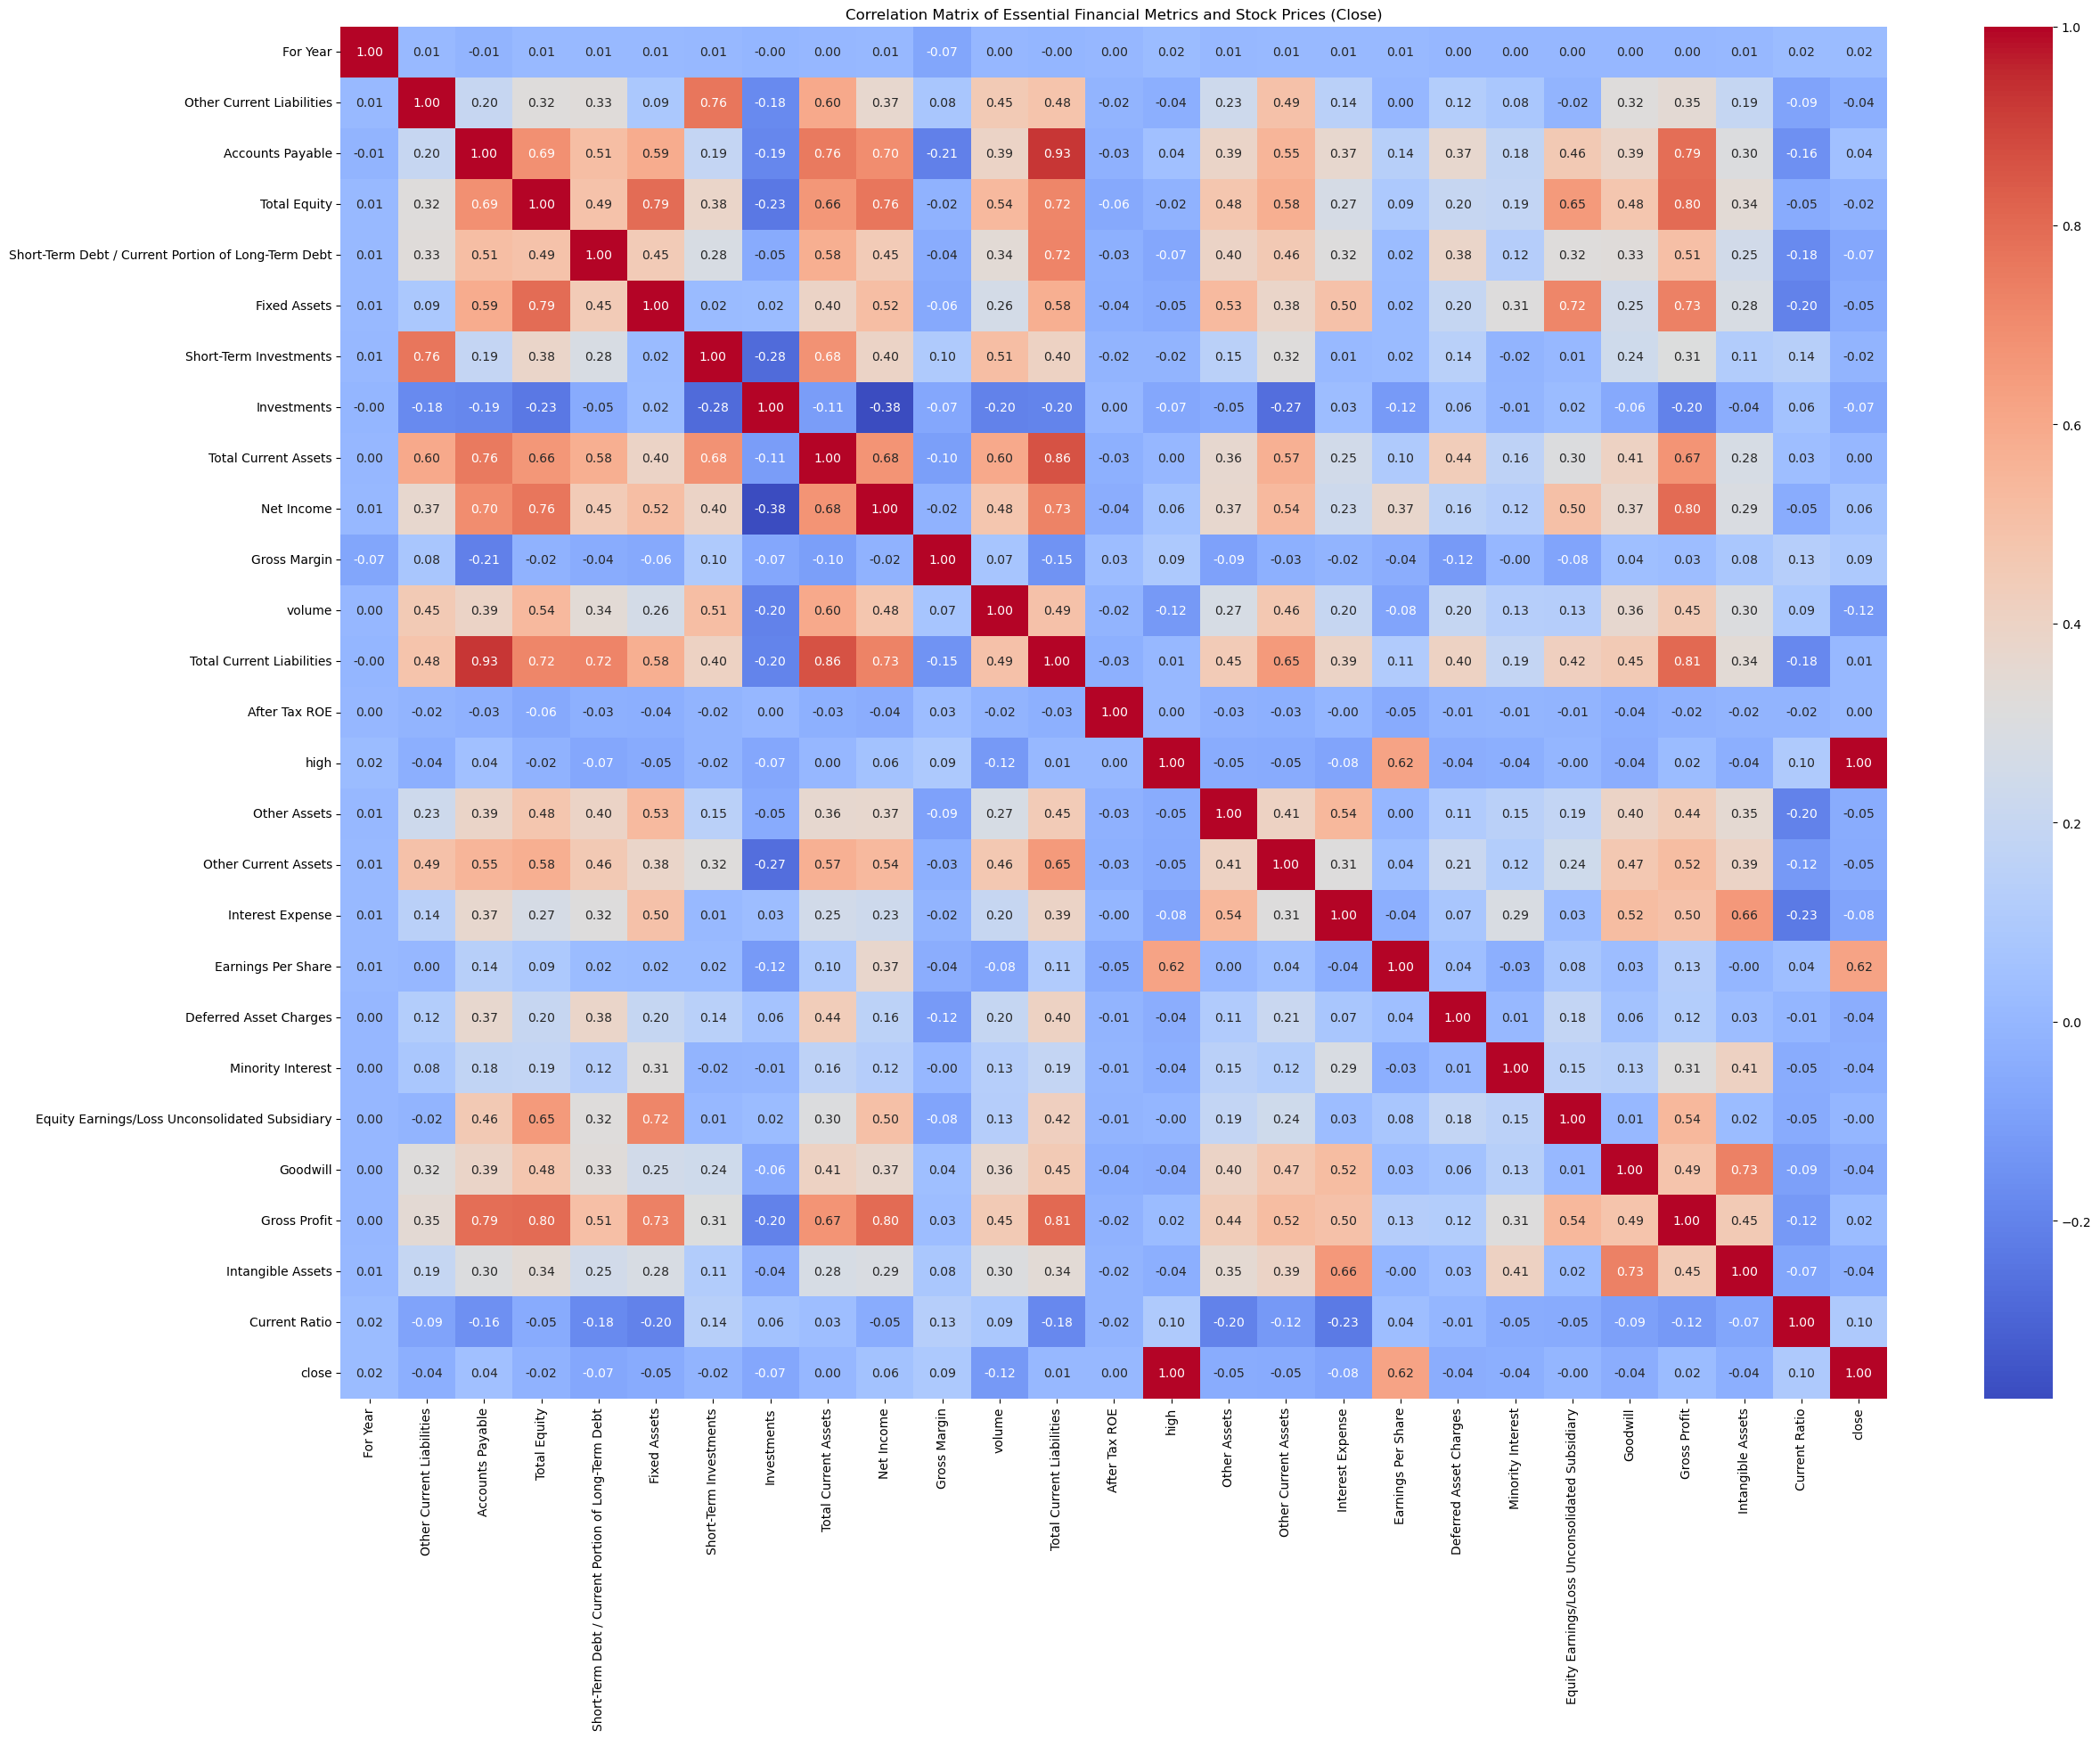

Histograms: Open


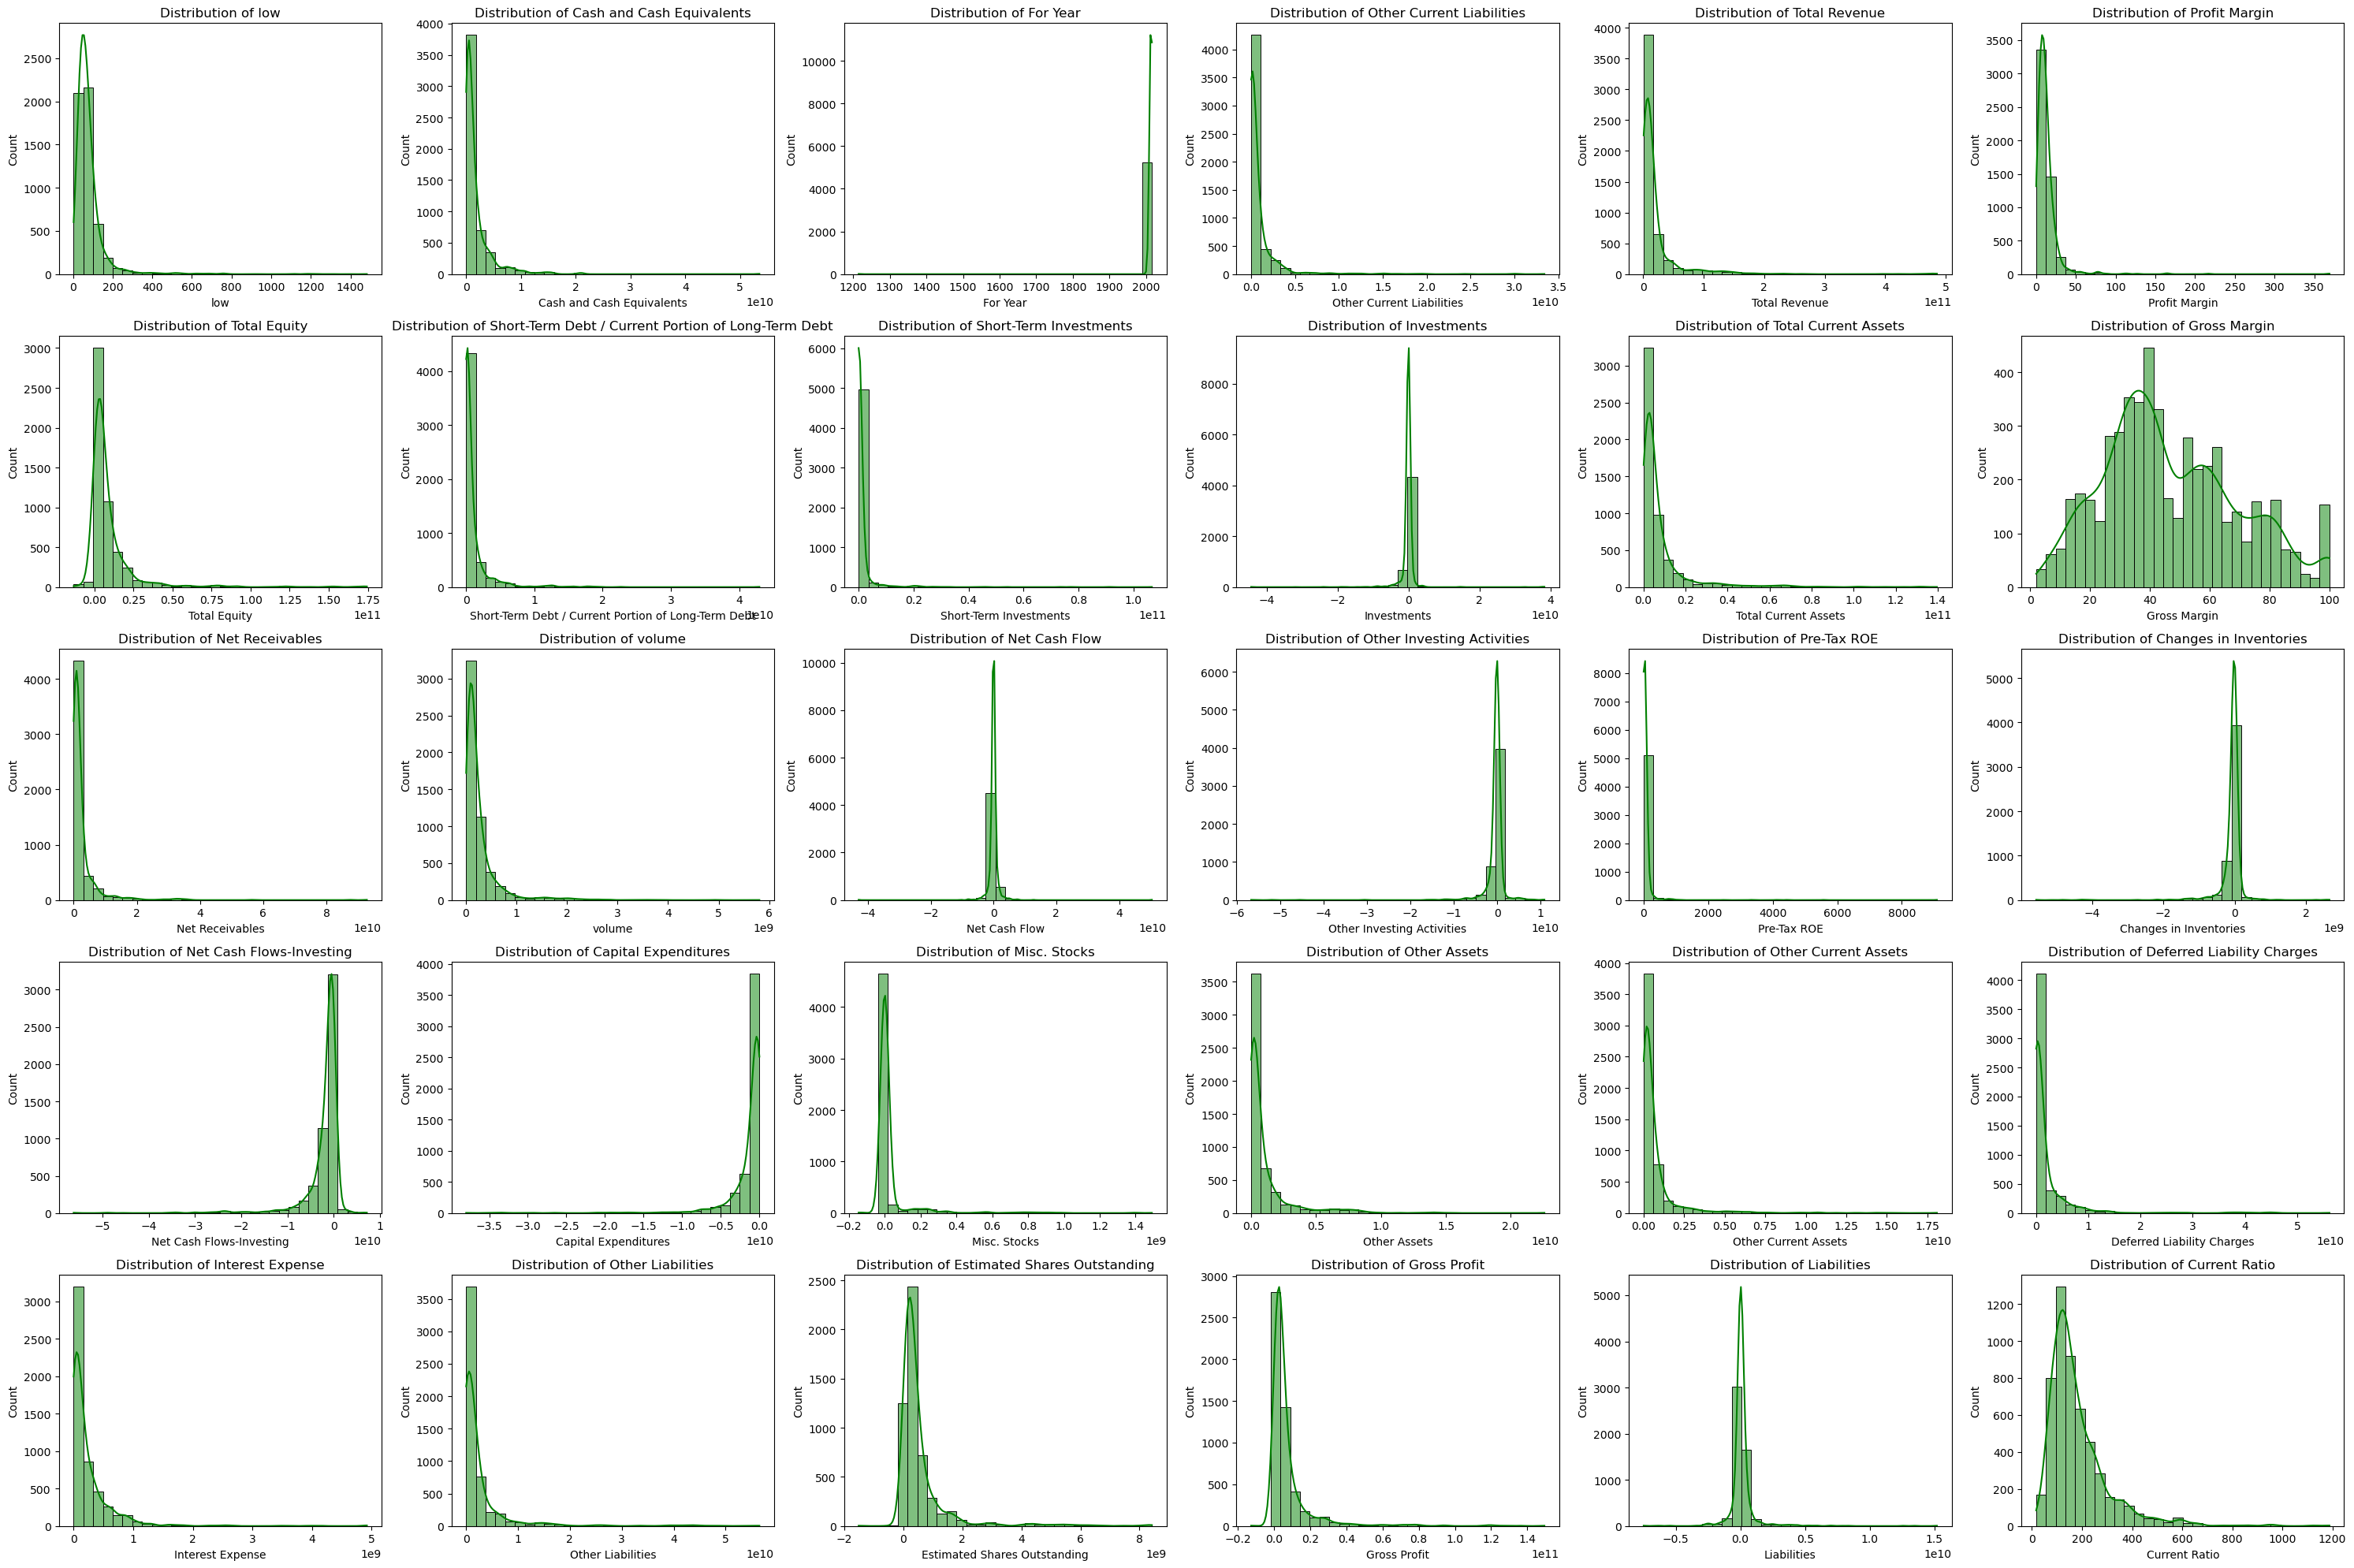

Histograms: Close


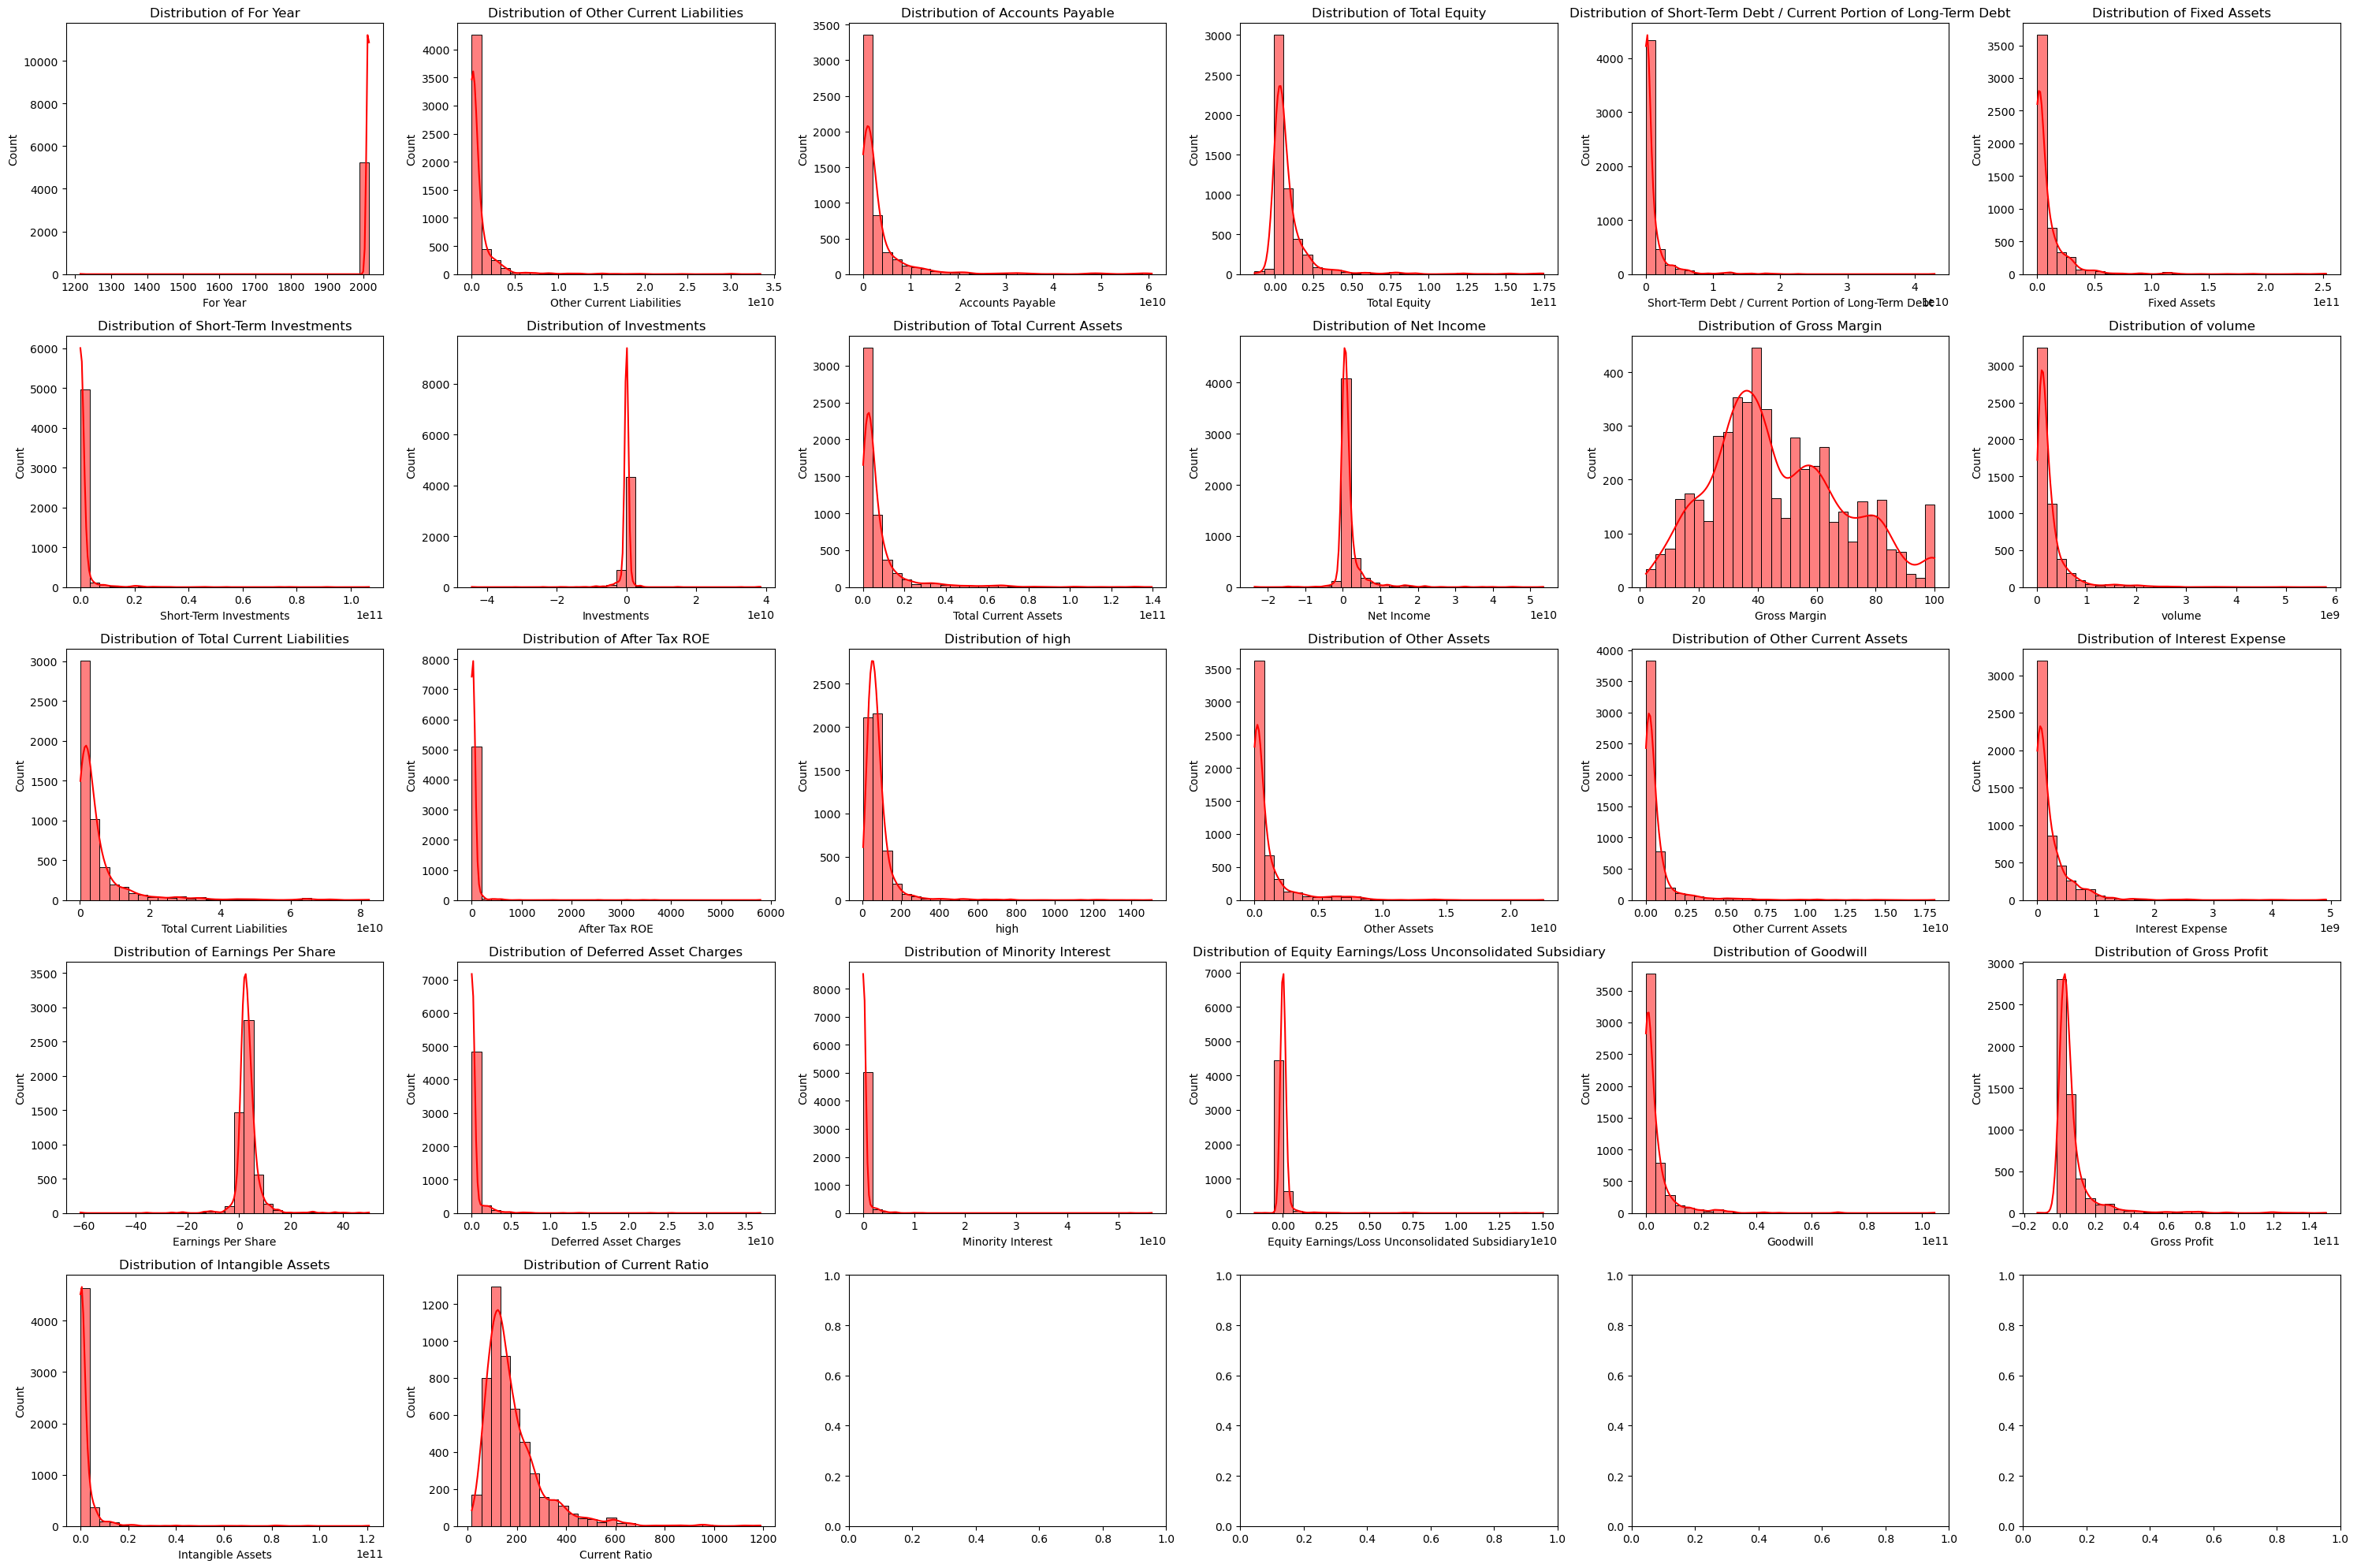

In [192]:
# Mark all open and close essential columns for analysis
# essential_columns = [
#     'open', 'close', 'high', 'low', 'Earnings Per Share', 'Liabilities', 'Cash Ratio', 'Quick Ratio', 
#     'Current Ratio', 'Gross Margin', 'Period Ending', 'date', 'Operating Income', 'Earnings Before Tax',
#     'Net Income Applicable to Common Shareholders', 'Net Income', 'Net Income-Cont. Operations', 'Income Tax', 
#     'Earnings Before Interest and Tax', 'Other Current Assets', 'Fixed Assets', 'Deferred Liability Charges',
#     'Sale and Purchase of Stock', 'Accounts Receivable', 'Long-Term Debt', 'Non-Recurring Items',
#     'Short-Term Debt / Current Portion of Long-Term Debt', 'Investments', 'Changes in Inventories',
#     'Interest Expense', 'Capital Surplus', 'volume', 'Estimated Shares Outstanding'
# ]

# # Filter the aligned data for essential columns only
# selected_data = aligned_data_cleaned[essential_columns]

# # Display a preview of the selected data
# print(selected_data.head())


# # Plot distribution of a few key financial metrics
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# sns.histplot(aligned_data['Earnings Per Share'], bins=30, kde=True, ax=axes[0, 0])
# axes[0, 0].set_title("Distribution of Earnings Per Share")

# sns.histplot(aligned_data['Total Liabilities'], bins=30, kde=True, ax=axes[0, 1])
# axes[0, 1].set_title("Distribution of Total Liabilities")

# sns.histplot(aligned_data['Capital Surplus'], bins=30, kde=True, ax=axes[1, 0])
# axes[1, 0].set_title("Distribution of Capital Surplus")

# sns.histplot(aligned_data['Estimated Shares Outstanding'], bins=30, kde=True, ax=axes[1, 1])
# axes[1, 1].set_title("Distribution of Estimated Shares Outstanding")

# plt.tight_layout()
# plt.show()

# selected_data = aligned_data_cleaned[['symbol'] + essential_columns]
# print(selected_data.head())
# print('shape:', selected_data.shape)

# =============================================================================

# Get Selected Data for Open and Close Prices
final_data_open = aligned_data_cleaned[['symbol'] + list(selected_data_open.columns) + ['open']]
final_data_close = aligned_data_cleaned[['symbol'] + list(selected_data_close.columns) + ['close']]

# SCATTER PLOTS ----------------------------------------------

# Plot scatter plots of selected features against open and close prices
# Open - 30 features
# Close - 26 features
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_open.columns):
    sns.scatterplot(x=feature, y='open', data=final_data_open, ax=axes[i // 6, i % 6])
    axes[i // 6, i % 6].set_title(f"{feature} vs. Open Price")
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_close.columns):
    sns.scatterplot(x=feature, y='close', data=final_data_close, ax=axes[i // 6, i % 6])
    axes[i // 6, i % 6].set_title(f"{feature} vs. Close Price")
    
plt.tight_layout()
plt.show()
    
    
# Correlation Heatmaps ----------------------------------------------
# Open
correlation_matrix_open = final_data_open.drop(columns=['symbol']).corr()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_open, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Open)")
plt.show()

# Close
correlation_matrix_close = final_data_close.drop(columns=['symbol']).corr()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_close, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Close)")
plt.show()


# Histograms ----------------------------------------------

# Plot histograms of selected features
# Open - 30 features
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

print("Histograms: Open")
for i, feature in enumerate(selected_data_open.columns):
    sns.histplot(final_data_open[feature], bins=30, kde=True, ax=axes[i // 6, i % 6], color='green')
    axes[i // 6, i % 6].set_title(f"Distribution of {feature}")
    
plt.tight_layout()
plt.show()

# Close - 26 features
print("Histograms: Close")
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_close.columns):
    sns.histplot(final_data_close[feature], bins=30, kde=True, ax=axes[i // 6, i % 6], color='red')
    axes[i // 6, i % 6].set_title(f"Distribution of {feature}")
    
plt.tight_layout()
plt.show()



In [193]:
# securities_df = pd.read_csv('data/securities.csv')
# securities_selected = securities_df[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

# final_df = selected_data.merge(securities_selected, left_on='symbol', right_on='Ticker symbol', how='left')

# final_df.drop(columns=['Ticker symbol'], inplace=True)
# print(final_df.head())
# final_df.shape

final_df_open = final_data_open.drop(columns=['symbol'])
final_df_close = final_data_close.drop(columns=['symbol'])
final_df_with_symbols_open = final_data_open
final_df_with_symbols_close = final_data_close
print('Final Dataframe Shape With Symbol (Open): ', final_df_with_symbols_open.shape)
print('Final Dataframe Shape With Symbol (Close): ', final_df_with_symbols_close.shape)
print('Final Dataframe Shape (Open): ', final_df_open.shape)
print('Final Dataframe Shape (Close): ', final_df_close.shape)
print('Open Features: ',final_df_open.columns)
print('Close Features: ', final_df_close.columns)


Final Dataframe Shape With Symbol (Open):  (5243, 32)
Final Dataframe Shape With Symbol (Close):  (5243, 28)
Final Dataframe Shape (Open):  (5243, 31)
Final Dataframe Shape (Close):  (5243, 27)
Open Features:  Index(['low', 'Cash and Cash Equivalents', 'For Year',
       'Other Current Liabilities', 'Total Revenue', 'Profit Margin',
       'Total Equity', 'Short-Term Debt / Current Portion of Long-Term Debt',
       'Short-Term Investments', 'Investments', 'Total Current Assets',
       'Gross Margin', 'Net Receivables', 'volume', 'Net Cash Flow',
       'Other Investing Activities', 'Pre-Tax ROE', 'Changes in Inventories',
       'Net Cash Flows-Investing', 'Capital Expenditures', 'Misc. Stocks',
       'Other Assets', 'Other Current Assets', 'Deferred Liability Charges',
       'Interest Expense', 'Other Liabilities', 'Estimated Shares Outstanding',
       'Gross Profit', 'Liabilities', 'Current Ratio', 'open'],
      dtype='object')
Close Features:  Index(['For Year', 'Other Current

In [194]:
######IMPLEMENTATION######

# import necessary libs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

# helper funcs
def predict(X, theta, degree):
    X_poly = add_polynomial_features(X, degree)
    return X_poly.dot(theta)

def add_polynomial_features(X, degree):
    X_poly = np.ones((X.shape[0], 1))  # Start with a column of ones (for the intercept)
    for d in range(1, degree + 1):
        X_poly = np.hstack((X_poly, X ** d))  # Add each polynomial degree column
    return X_poly

def polynomial_regression(X, y, degree, learning_rate, n_iterations, alpha, max_gradient=1e4):
    X_poly = add_polynomial_features(X, degree)
    y = y.reshape(-1, 1)
    m, n = X_poly.shape

    # Initialize theta (parameter vector) with zeros
    theta = np.zeros((n, 1))

    # Gradient descent
    for i in range(n_iterations):
        predictions = X_poly.dot(theta)
        errors = predictions - y
        gradients = (2 / m) * X_poly.T.dot(errors) + (2 * alpha * theta)

        # Clip gradients to prevent excessively large updates
        gradients = np.clip(gradients, -max_gradient, max_gradient)

        # Update theta
        theta -= learning_rate * gradients

    return theta
    

In [195]:
def compute_additional_metrics(y_test, y_pred):
    # y_test and y_pred to numpy arrays
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()

    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # directional accuracy
    actual_direction = np.sign(y_test[1:] - y_test[:-1])
    predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100

    # correlation coefficient
    correlation = np.corrcoef(y_test, y_pred)[0, 1]

    # Sharpe Ratio
    # calculate predicted returns
    predicted_returns = y_pred[1:] - y_pred[:-1]

    if np.std(predicted_returns) != 0:
        sharpe_ratio = (np.mean(predicted_returns) / np.std(predicted_returns)) * np.sqrt(252)
    else:
        sharpe_ratio = 0

    return mae, mape, directional_accuracy, correlation, sharpe_ratio

In [196]:
# Func to run all models and output results
def train_and_evaluate_model(X, y, dataset_name):
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

    # SKLEARN LINEAR REGRESSION ----------------------------------------------

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Linear Regression'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Linear Regression")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # SKLEARN POLYNOMIAL REGRESSION DEGREE 1 ----------------------------------------------

    poly1 = PolynomialFeatures(degree=1)
    X_train_poly1 = poly1.fit_transform(X_train_scaled)
    X_test_poly1 = poly1.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly1, y_train)
    y_pred = model.predict(X_test_poly1)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Polynomial Regression Degree 1'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Polynomial Regression Degree 1")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # SKLEARN POLYNOMIAL REGRESSION DEGREE 2 ----------------------------------------------

    poly2 = PolynomialFeatures(degree=2)
    X_train_poly2 = poly2.fit_transform(X_train_scaled)
    X_test_poly2 = poly2.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly2, y_train)
    y_pred = model.predict(X_test_poly2)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Polynomial Regression Degree 2'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Polynomial Regression Degree 2")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # CUSTOM POLYNOMIAL REGRESSION ----------------------------------------------

    # test polynomial degrees 1-3
    for degree in range(1, 4):
        theta = polynomial_regression(
            X_train_scaled, y_train.values, degree=degree,
            learning_rate=0.001, n_iterations=10000, alpha=0.01
        )

        # Ensure theta is valid
        if not np.isnan(theta).any():
            # predict on the test set
            y_pred = predict(X_test_scaled, theta, degree)

            # eval
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # compute metrics
            mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

            model_name = f'Custom Polynomial Regression Degree {degree}'
            results[model_name] = {
                'MSE': mse,
                'R2': r2,
                'MAE': mae,
                'MAPE': mape,
                'Directional Accuracy': directional_accuracy,
                'Correlation Coefficient': correlation,
                'Sharpe Ratio': sharpe_ratio
            }

            print(f"{dataset_name} - Custom Polynomial Regression Degree {degree}")
            print("Mean Squared Error:", mse)
            print("R-squared Score:", r2)
            print()

    # K-NEAREST NEIGHBORS REGRESSION ----------------------------------------------

    knn_neighbors = [3, 5, 7]
    for k in knn_neighbors:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # compute metrics
        mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

        model_name = f'KNN Regression (k={k})'
        results[model_name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape,
            'Directional Accuracy': directional_accuracy,
            'Correlation Coefficient': correlation,
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"{dataset_name} - KNN Regression (k={k})")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print()

    # DECISION TREE REGRESSION ----------------------------------------------

    max_depths = [3, 5, 7, None]
    for depth in max_depths:
        dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
        dt.fit(X_train_scaled, y_train)
        y_pred = dt.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # compute metrics
        mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

        depth_label = f'Decision Tree Regression (max_depth={depth})'
        results[depth_label] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape,
            'Directional Accuracy': directional_accuracy,
            'Correlation Coefficient': correlation,
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"{dataset_name} - Decision Tree Regression (max_depth={depth})")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print()

    return results

In [197]:
# define target variable y_open and features X_open
y_open = final_df_open['open']
X_open = final_df_open.drop(columns=['open'])

# call the func train_and_evaluate_model on the open price dataset
print("Training and evaluating models on the Open Price Dataset:")
results_open = train_and_evaluate_model(X_open, y_open, "Open Price Dataset")

Training and evaluating models on the Open Price Dataset:
Open Price Dataset - Linear Regression
Mean Squared Error: 0.14078552286063203
R-squared Score: 0.9999810604755038

Open Price Dataset - Polynomial Regression Degree 1
Mean Squared Error: 0.14078552286065235
R-squared Score: 0.9999810604755038

Open Price Dataset - Polynomial Regression Degree 2
Mean Squared Error: 0.12098444405327301
R-squared Score: 0.9999837242651428

Open Price Dataset - Custom Polynomial Regression Degree 1
Mean Squared Error: 1.4507520488252454
R-squared Score: 0.9998048339530348

Open Price Dataset - Custom Polynomial Regression Degree 2
Mean Squared Error: 26112.80600147213
R-squared Score: -2.512890522265872

Open Price Dataset - Custom Polynomial Regression Degree 3
Mean Squared Error: 67923395.86105096
R-squared Score: -9136.564670259764

Open Price Dataset - KNN Regression (k=3)
Mean Squared Error: 166.06880075991486
R-squared Score: 0.9776591793237128

Open Price Dataset - KNN Regression (k=5)
Mean 

In [198]:
# define target variable y_close and features X_close
y_close = final_df_close['close']
X_close = final_df_close.drop(columns=['close'])

# call the func train_and_evaluate_model on the close price dataset
print("Training and evaluating models on the Close Price Dataset:")
results_close = train_and_evaluate_model(X_close, y_close, "Close Price Dataset")

Training and evaluating models on the Close Price Dataset:
Close Price Dataset - Linear Regression
Mean Squared Error: 0.1155770560381581
R-squared Score: 0.9999844578460584

Close Price Dataset - Polynomial Regression Degree 1
Mean Squared Error: 0.11557705603813191
R-squared Score: 0.9999844578460584

Close Price Dataset - Polynomial Regression Degree 2
Mean Squared Error: 0.11261241906881564
R-squared Score: 0.9999848565138021

Close Price Dataset - Custom Polynomial Regression Degree 1
Mean Squared Error: 5.297036959285119
R-squared Score: 0.9992876841937498

Close Price Dataset - Custom Polynomial Regression Degree 2
Mean Squared Error: 26127.991863382984
R-squared Score: -2.5135457299841044

Close Price Dataset - Custom Polynomial Regression Degree 3
Mean Squared Error: 87632687.71770696
R-squared Score: -11783.352098221814

Close Price Dataset - KNN Regression (k=3)
Mean Squared Error: 182.03735240068045
R-squared Score: 0.9755206383418473

Close Price Dataset - KNN Regression (

In [199]:
# Compare Results ----------------------------------------------

print("Comparison of Model Performance between Open and Close Price Datasets:")

# init a list to store the results
comparison_records = []

# populate the comparison records list
for model_name in results_open.keys():
    comparison_records.append({
        'Model': model_name,
        'Dataset': 'Open Price',
        'Mean Squared Error': results_open[model_name]['MSE'],
        'R-squared Score': results_open[model_name]['R2']
    })
    comparison_records.append({
        'Model': model_name,
        'Dataset': 'Close Price',
        'Mean Squared Error': results_close[model_name]['MSE'],
        'R-squared Score': results_close[model_name]['R2']
    })

comparison_df = pd.DataFrame(comparison_records)

print(comparison_df)

# find the highest performing model based on combined score of MSE and R2

from sklearn.preprocessing import MinMaxScaler

# normalize MSE and R-squared Score
scaler = MinMaxScaler()
comparison_df[['MSE_Scaled', 'R2_Scaled']] = scaler.fit_transform(
    comparison_df[['Mean Squared Error', 'R-squared Score']]
)

# calculate a combined score
comparison_df['Combined Score'] = comparison_df['MSE_Scaled'] + (1 - comparison_df['R2_Scaled'])

best_combined_score = comparison_df['Combined Score'].min()
best_model_combined = comparison_df[comparison_df['Combined Score'] == best_combined_score]

print("\nHighest Performing Model based on Combined MSE and R2 Score:")
print(best_model_combined['Model'].iloc[0])

Comparison of Model Performance between Open and Close Price Datasets:
                                        Model      Dataset  \
0                           Linear Regression   Open Price   
1                           Linear Regression  Close Price   
2              Polynomial Regression Degree 1   Open Price   
3              Polynomial Regression Degree 1  Close Price   
4              Polynomial Regression Degree 2   Open Price   
5              Polynomial Regression Degree 2  Close Price   
6       Custom Polynomial Regression Degree 1   Open Price   
7       Custom Polynomial Regression Degree 1  Close Price   
8       Custom Polynomial Regression Degree 2   Open Price   
9       Custom Polynomial Regression Degree 2  Close Price   
10      Custom Polynomial Regression Degree 3   Open Price   
11      Custom Polynomial Regression Degree 3  Close Price   
12                       KNN Regression (k=3)   Open Price   
13                       KNN Regression (k=3)  Close Price   

In [200]:
#Model Tweaking using Ensemble Learning

# --- BAGGING ---
from sklearn.ensemble import BaggingRegressor

def bag(X, y, model, dataset_name, model_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    bagging = BaggingRegressor(estimator = model, n_estimators = 50, random_state = 42)

    bagging.fit(X_train_scaled, y_train)
    y_pred = bagging.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Bagging {model_name}")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

# --- BOOSTING ---
from sklearn.ensemble import GradientBoostingRegressor

def boost(X, y, dataset_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    boosting.fit(X_train_scaled, y_train)
    y_pred = boosting.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Boosting with Gradient Regressor")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

# --- STACKING ---
from sklearn.ensemble import StackingRegressor

def stack(X, y, models, final_model, dataset_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacking = StackingRegressor(estimators=models, final_estimator=final_model, cv=5)

    stacking.fit(X_train_scaled, y_train)
    y_pred = stacking.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Stacking Regressor with all models")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

In [201]:
# USAGE of Ensemble Techniques

# func to run Bagging, Boosting, and Stacking
def ensemble(X, y, dataset_name):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- BAGGING ---

    bagging_models = {
        'Linear Regression Bagging': BaggingRegressor(estimator=LinearRegression(), n_estimators=50, random_state=42, oob_score=True),
        'KNN Bagging': BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=5), n_estimators=50, random_state=42, oob_score=True),
        'Decision Tree Bagging': BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5, random_state=42), n_estimators=50, random_state=42, oob_score=True)
    }

    for model_name, model in bagging_models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        oob_score = model.oob_score_

        # compute metrics
        mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

        results[model_name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape,
            'Directional Accuracy': directional_accuracy,
            'Correlation Coefficient': correlation,
            'Sharpe Ratio': sharpe_ratio,
            'OOB Score': oob_score
        }

        print(f"{dataset_name} - {model_name}")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print("Out-of-Bag Score:", oob_score)
        print()

    # --- BOOSTING ---

    boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    boosting.fit(X_train_scaled, y_train)
    y_pred = boosting.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Boosting'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Boosting with Gradient Regressor")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # --- STACKING ---

    estimators = [
        ('Linear Regression', LinearRegression()),
        ('KNN', KNeighborsRegressor(n_neighbors=5)),
        ('Decision Tree', DecisionTreeRegressor(max_depth=5, random_state=42))
    ]
    stacking = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=5)
    stacking.fit(X_train_scaled, y_train)
    y_pred = stacking.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Stacking'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Stacking Regressor with Linear Regression, KNN, and Decision Tree")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

In [202]:
#Ensemble on open price dataset
open_ensemble_results = ensemble(X_open, y_open, "Open Price Dataset")

Open Price Dataset - Linear Regression Bagging
Mean Squared Error: 0.14132145006430424
R-squared Score: 0.9999809883785566
Out-of-Bag Score: 0.9999831924358777

Open Price Dataset - KNN Bagging
Mean Squared Error: 259.4056446165894
R-squared Score: 0.9651028070156645
Out-of-Bag Score: 0.9705009372608803

Open Price Dataset - Decision Tree Bagging
Mean Squared Error: 9.493344273204778
R-squared Score: 0.9987228841235956
Out-of-Bag Score: 0.9972771969364806

Open Price Dataset - Boosting with Gradient Regressor
Mean Squared Error: 2.425114163888517
R-squared Score: 0.9996737554531192

Open Price Dataset - Stacking Regressor with Linear Regression, KNN, and Decision Tree
Mean Squared Error: 0.14380999365993766
R-squared Score: 0.9999806536010069



In [203]:
#Ensemble on close price dataset
close_ensemble_results = ensemble(X_close, y_close, "Close Price Dataset")

Close Price Dataset - Linear Regression Bagging
Mean Squared Error: 0.11595523565868124
R-squared Score: 0.9999844069905851
Out-of-Bag Score: 0.9999869837011096

Close Price Dataset - KNN Bagging
Mean Squared Error: 299.06812734798615
R-squared Score: 0.9597829964387548
Out-of-Bag Score: 0.9704897564869869

Close Price Dataset - Decision Tree Bagging
Mean Squared Error: 11.262107350509686
R-squared Score: 0.9984855350002056
Out-of-Bag Score: 0.9971915004185804

Close Price Dataset - Boosting with Gradient Regressor
Mean Squared Error: 4.288330536521516
R-squared Score: 0.9994233293731819

Close Price Dataset - Stacking Regressor with Linear Regression, KNN, and Decision Tree
Mean Squared Error: 0.11212625830399976
R-squared Score: 0.9999849218899737



In [204]:
###### ANALYSIS ######

# import necessary libs
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def compile_results(individual_results, ensemble_results, dataset_name):
    records = []
    for model_name, metrics in individual_results.items():
        record = {
            'Model': model_name,
            'MSE': metrics['MSE'],
            'R2': metrics['R2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'Directional Accuracy': metrics['Directional Accuracy'],
            'Correlation Coefficient': metrics['Correlation Coefficient'],
            'Sharpe Ratio': metrics['Sharpe Ratio'],
            'Type': 'Individual'
        }
        records.append(record)
    for model_name, metrics in ensemble_results.items():
        record = {
            'Model': model_name,
            'MSE': metrics['MSE'],
            'R2': metrics['R2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'Directional Accuracy': metrics['Directional Accuracy'],
            'Correlation Coefficient': metrics['Correlation Coefficient'],
            'Sharpe Ratio': metrics['Sharpe Ratio'],
            'Type': 'Ensemble'
        }
        records.append(record)
    results_df = pd.DataFrame(records)
    results_df['Dataset'] = dataset_name
    return results_df

# compile results for open dataset
open_results_df = compile_results(results_open, open_ensemble_results, 'Open Price')

# compile results for close dataset
close_results_df = compile_results(results_close, close_ensemble_results, 'Close Price')

# combine datasets
combined_results_df = pd.concat([open_results_df, close_results_df], ignore_index=True)

# reset pandas display options
pd.reset_option('display.float_format')

# convert metrics to numeric if they are not already
numeric_cols = ['MSE', 'R2', 'MAE', 'MAPE', 'Directional Accuracy', 'Correlation Coefficient', 'Sharpe Ratio']
for col in numeric_cols:
    combined_results_df[col] = pd.to_numeric(combined_results_df[col], errors='coerce')

combined_results_df['MSE_formatted'] = combined_results_df['MSE'].apply(lambda x: '{:,.6f}'.format(x))
combined_results_df['R2_formatted'] = combined_results_df['R2'].apply(lambda x: '{:.6f}'.format(x))
combined_results_df['MAE_formatted'] = combined_results_df['MAE'].apply(lambda x: '{:,.6f}'.format(x))
combined_results_df['MAPE_formatted'] = combined_results_df['MAPE'].apply(lambda x: '{:.2f}%'.format(x))
combined_results_df['Directional Accuracy_formatted'] = combined_results_df['Directional Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
combined_results_df['Correlation Coefficient_formatted'] = combined_results_df['Correlation Coefficient'].apply(lambda x: '{:.6f}'.format(x))
combined_results_df['Sharpe Ratio_formatted'] = combined_results_df['Sharpe Ratio'].apply(lambda x: '{:.6f}'.format(x))

# display combined results
print("Combined Model Performance on Open and Close Price Datasets:")
display(combined_results_df[['Model', 'Dataset', 'Type', 'MSE_formatted', 'R2_formatted', 'MAE_formatted',
                             'MAPE_formatted', 'Directional Accuracy_formatted', 'Correlation Coefficient_formatted',
                             'Sharpe Ratio_formatted']])


from sklearn.preprocessing import MinMaxScaler

# metrics
metrics_to_maximize = ['R2', 'Directional Accuracy', 'Correlation Coefficient', 'Sharpe Ratio']
metrics_to_minimize = ['MSE', 'MAE', 'MAPE']

# func to compute combined score
def compute_combined_score(df):
    # init scaler
    scaler = MinMaxScaler()
    
    # scale metrics to maximize
    for metric in metrics_to_maximize:
        df[metric + '_scaled'] = scaler.fit_transform(df[[metric]])
    
    # scale metrics to minimize and invert them
    for metric in metrics_to_minimize:
        df[metric + '_scaled'] = scaler.fit_transform(df[[metric]])
        df[metric + '_scaled'] = 1 - df[metric + '_scaled']  # Invert so that higher is better
    
    # compute combined score by summing scaled metrics
    metric_columns = [metric + '_scaled' for metric in metrics_to_maximize + metrics_to_minimize]
    df['Combined_Score'] = df[metric_columns].sum(axis=1)
    
    return df

# open
open_df = combined_results_df[combined_results_df['Dataset'] == 'Open Price'].copy()
open_df = compute_combined_score(open_df)

# print best model for open
best_model_open = open_df.loc[open_df['Combined_Score'].idxmax()]

print(f"\nBest Model for Open Price Dataset based on Combined Score:")
print(f"Model: {best_model_open['Model']}")
print(f"Combined Score: {best_model_open['Combined_Score']}")
print(f"Type: {best_model_open['Type']}")
print(f"MSE: {best_model_open['MSE_formatted']}")
print(f"R2: {best_model_open['R2_formatted']}")
print(f"MAE: {best_model_open['MAE_formatted']}")
print(f"MAPE: {best_model_open['MAPE_formatted']}")
print(f"Directional Accuracy: {best_model_open['Directional Accuracy_formatted']}")
print(f"Correlation Coefficient: {best_model_open['Correlation Coefficient_formatted']}")
print(f"Sharpe Ratio: {best_model_open['Sharpe Ratio_formatted']}")

# close
close_df = combined_results_df[combined_results_df['Dataset'] == 'Close Price'].copy()
close_df = compute_combined_score(close_df)

# print best model for close
best_model_close = close_df.loc[close_df['Combined_Score'].idxmax()]

print(f"\nBest Model for Close Price Dataset based on Combined Score:")
print(f"Model: {best_model_close['Model']}")
print(f"Combined Score: {best_model_close['Combined_Score']}")
print(f"Type: {best_model_close['Type']}")
print(f"MSE: {best_model_close['MSE_formatted']}")
print(f"R2: {best_model_close['R2_formatted']}")
print(f"MAE: {best_model_close['MAE_formatted']}")
print(f"MAPE: {best_model_close['MAPE_formatted']}")
print(f"Directional Accuracy: {best_model_close['Directional Accuracy_formatted']}")
print(f"Correlation Coefficient: {best_model_close['Correlation Coefficient_formatted']}")
print(f"Sharpe Ratio: {best_model_close['Sharpe Ratio_formatted']}")

Combined Model Performance on Open and Close Price Datasets:


Model      Dataset        Type  \
0                           Linear Regression   Open Price  Individual   
1              Polynomial Regression Degree 1   Open Price  Individual   
2              Polynomial Regression Degree 2   Open Price  Individual   
3       Custom Polynomial Regression Degree 1   Open Price  Individual   
4       Custom Polynomial Regression Degree 2   Open Price  Individual   
5       Custom Polynomial Regression Degree 3   Open Price  Individual   
6                        KNN Regression (k=3)   Open Price  Individual   
7                        KNN Regression (k=5)   Open Price  Individual   
8                        KNN Regression (k=7)   Open Price  Individual   
9      Decision Tree Regression (max_depth=3)   Open Price  Individual   
10     Decision Tree Regression (max_depth=5)   Open Price  Individual   
11     Decision Tree Regression (max_depth=7)   Open Price  Individual   
12  Decision Tree Regression (max_depth=None)   Open Price  Individual   
13                  Linear Regression Bagging   Open Price    Ensemble   
14                                KNN Bagging   Open Price    Ensemble   
15                      Decision Tree Bagging   Open Price    Ensemble   
16                                   Boosting   Open Price    Ensemble   
17                                   Stacking   Open Price    Ensemble   
18                          Linear Regression  Close Price  Individual   
19             Polynomial Regression Degree 1  Close Price  Individual   
20             Polynomial Regression Degree 2  Close Price  Individual   
21      Custom Polynomial Regression Degree 1  Close Price  Individual   
22      Custom Polynomial Regression Degree 2  Close Price  Individual   
23      Custom Polynomial Regression Degree 3  Close Price  Individual   
24                       KNN Regression (k=3)  Close Price  Individual   
25                       KNN Regression (k=5)  Close Price  Individual   
26                       KNN Regression (k=7)  Close Price  Individual   
27     Decision Tree Regression (max_depth=3)  Close Price  Individual   
28     Decision Tree Regression (max_depth=5)  Close Price  Individual   
29     Decision Tree Regression (max_depth=7)  Close Price  Individual   
30  Decision Tree Regression (max_depth=None)  Close Price  Individual   
31                  Linear Regression Bagging  Close Price    Ensemble   
32                                KNN Bagging  Close Price    Ensemble   
33                      Decision Tree Bagging  Close Price    Ensemble   
34                                   Boosting  Close Price    Ensemble   
35                                   Stacking  Close Price    Ensemble   

        MSE_formatted   R2_formatted MAE_formatted MAPE_formatted  \
0            0.140786       0.999981      0.203928          0.31%   
1            0.140786       0.999981      0.203928          0.31%   
2            0.120984       0.999984      0.182124          0.29%   
3            1.450752       0.999805      0.791296          1.25%   
4       26,112.806001      -2.512891      7.596889         26.85%   
5   67,923,395.861051   -9136.564670  1,558.204832       3372.78%   
6          166.068801       0.977659      7.253003         10.61%   
7          274.639979       0.963053      9.090085         13.89%   
8          335.920630       0.954809     10.649738         17.48%   
9          349.515667       0.952981     13.677188         27.99%   
10          28.378094       0.996182      3.793924          7.61%   
11           6.212299       0.999164      1.136758          2.00%   
12           3.903940       0.999475      0.484383          0.47%   
13           0.141321       0.999981      0.204097          0.32%   
14         259.405645       0.965103      8.982612         14.43%   
15           9.493344       0.998723      1.491697          4.50%   
16           2.425114       0.999674      0.769763          1.04%   
17           0.143810       0.999981      0.207797         


Best Model for Open Price Dataset based on Combined Score:
Model: Custom Polynomial Regression Degree 1
Combined Score: 6.794581768069342
Type: Individual
MSE: 1.450752
R2: 0.999805
MAE: 0.791296
MAPE: 1.25%
Directional Accuracy: 99.71%
Correlation Coefficient: 0.999981
Sharpe Ratio: -0.001553

Best Model for Close Price Dataset based on Combined Score:
Model: KNN Regression (k=7)
Combined Score: 6.788300848307437
Type: Individual
MSE: 377.365669
R2: 0.949254
MAE: 10.215527
MAPE: 15.39%
Directional Accuracy: 91.13%
Correlation Coefficient: 0.976103
Sharpe Ratio: 0.000638
